In [1]:
from pathlib import Path
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from data_scripts import *

tex_fonts = {
    # Use LaTeX to write all text
    # "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

sns.set_theme(
    # context="talk",
    context="paper",
    # rc={"figure.figsize": (8, 6)},
    palette="bright",
    style="whitegrid",
    rc=tex_fonts,
)

CONVERGED = False
NUM_SIMS = 5
YEAR = 365 * 24 * 60 * 60
USE_SIMULATED_TIME = False

if USE_SIMULATED_TIME:
    X_LABEL = "Simulated time, years"
else:
    X_LABEL = "Time step number"


data = {
    # "CPR and Schur only": load_data('../1/thermal_dynamic', n_newest=NUM_SIMS),
    # "Many solvers": load_data("thermal_many_solvers", n_newest=NUM_SIMS),
    "Many solvers gp": load_data("thermal_many_solvers_gp", n_newest=1),
}

save_media_path = Path("media")
save_media_path.mkdir(exist_ok=True)

Loading data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy


/home/firedrake/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


Many solvers gp 550.0350406169891 0.0


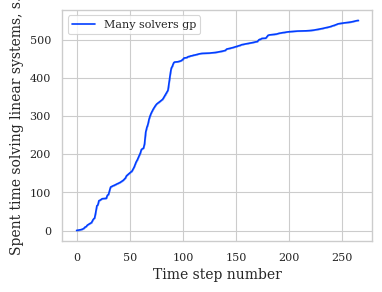

In [2]:
color_iter = -1
best_time = float("inf")
plt.figure(figsize=(4, 3))
for name, values in data.items():
    result = []
    times = []
    color_iter += 1

    for perf in values:
        vals = np.cumsum(
            sum_per_time_step(
                make_solve_linear_system_time(perf, converged=CONVERGED),
                perf,
                converged=CONVERGED,
            )
        )
        result.append(vals)
        if USE_SIMULATED_TIME:
            times.append(make_simulation_time(perf, converged=CONVERGED) / YEAR)
        else:
            times.append(np.arange(len(vals)))

    total = []
    t_end = []
    interp_data_list = []
    x_space = np.linspace(times[0][0], times[0][-1], 1000)
    for time, result in zip(times, result):
        total.append(result[-1])
        t_end.append(time[-1])
        interp_data_list.append(np.interp(x_space, time, result))

    interp_data = np.array(interp_data_list)
    max_ = np.max(interp_data, axis=0)
    min_ = np.min(interp_data, axis=0)
    mean = np.mean(interp_data, axis=0)
    if mean[-1] < best_time:
        best_time = mean[-1]
        best = mean
    plt.fill_between(x_space, min_, max_, color=f"C{color_iter}", alpha=0.3)
    plt.plot(x_space, mean, color=f"C{color_iter}", label=name)
    print(name, np.mean(total), np.max(total) - np.min(total))
    if USE_SIMULATED_TIME:
        assert np.allclose(t_end, t_end[0], rtol=1e-10)

plt.legend()
plt.xlabel(X_LABEL)
plt.ylabel("Spent time solving linear systems, s.")

if save_media_path is not None:
    plt.savefig(save_media_path / "thermal_performance.pdf", bbox_inches="tight")

Many solvers gp


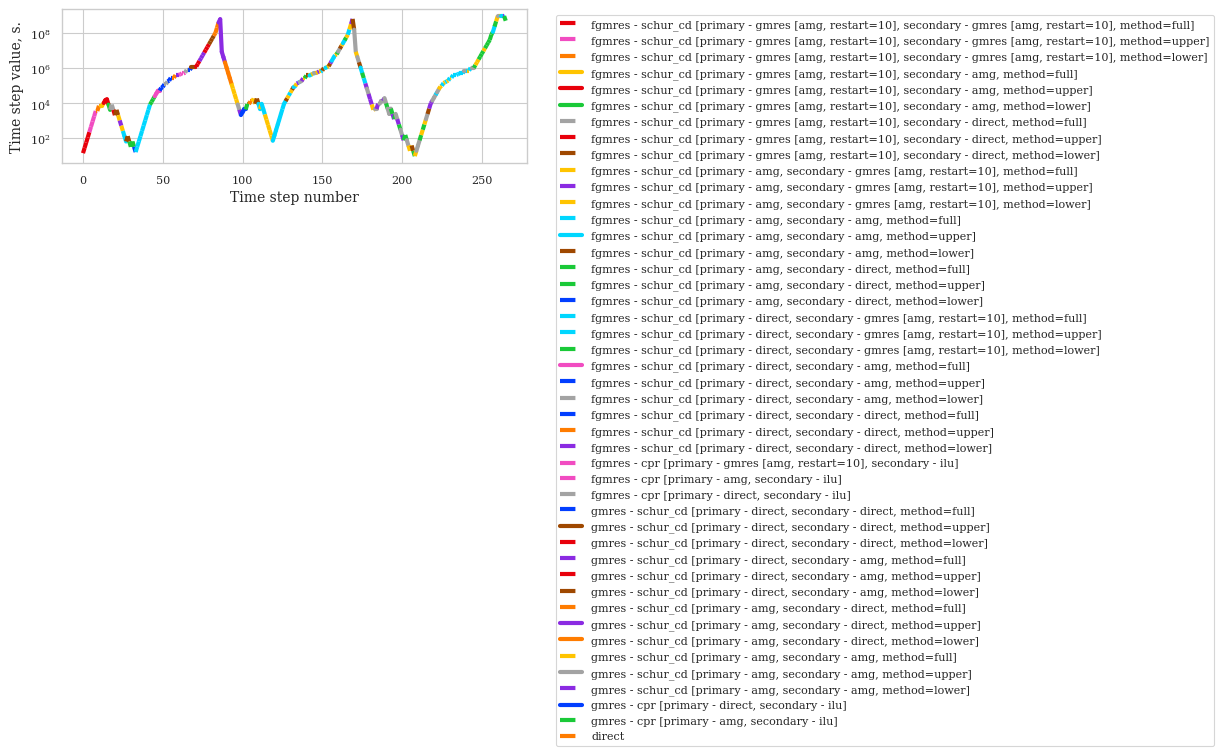

0 gmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
4 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
5 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
6 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
7 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
8 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
9 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
10 gmres - schur_cd [primary - direct, secondary - direct, method=full]
11 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
12 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
13 gmres - schur_cd [primary - direct, se

In [3]:
def make_solver_colors(data: Sequence[SolverSelectionData]):
    def make_hashable(x: SolverSelectionData):
        return tuple(x.prediction.decision.subsolvers.items())

    from thermal_solvers import make_thermal_solver_space

    solver_space = make_thermal_solver_space("full")
    all_solvers = solver_space.get_all_solvers()

    subsolvers = list({make_hashable(x) for x in data})
    subsolvers_to_number = {subsolver: i for i, subsolver in enumerate(subsolvers)}

    solver_names = dict()
    for subsolvers, i in subsolvers_to_number.items():
        config = None
        tested = list(dict(subsolvers).values())
        for solver_template in all_solvers:
            expected = list(solver_template.subsolvers.values())
            if tested == expected:
                config = solver_space.config_from_decision(
                    solver_template.use_defaults(), optimized_only=True
                )
                break
        assert config is not None
        solver_names[i] = solver_space.format_config(config)

    return [subsolvers_to_number[make_hashable(entry)] for entry in data], solver_names


def color_solvers(x, values, colors, names):
    lw = 3
    if not USE_SIMULATED_TIME:
        x = np.arange(values.size)

    names = names.copy()
    for i in range(len(x)):
        x_ = x[i : i + 2]
        val = values[i : i + 2]
        color = colors[i]
        args = {}
        if color in names:
            name = names.pop(color)
            # name = color
            args["label"] = name
        if color > 9:
            args["linestyle"] = "--"
        plt.plot(x_, val, linewidth=lw, c=f"C{color}", **args)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


for name, vals in data.items():
    colors_list = []
    time_step_list = []
    inlet_rate_list = []
    sim_time_list = []
    for perf in vals:
        solver_colors, solver_names = make_solver_colors(perf)
        colors_list.append(solver_colors)
        time_step_list.append(make_time_step(perf, converged=CONVERGED))
        inlet_rate_list.append(make_inlet_rate(perf, converged=CONVERGED))
        sim_time_list.append(make_simulation_time(perf, converged=CONVERGED))

    print(name)
    # plt.figure(figsize=(6, 2))
    # color_solvers(sim_time_list[0], inlet_rate_list[0], colors_list[0], solver_names)
    # plt.ylabel("Source rate, $m^3 s^{-1}$.")
    # plt.xlabel(X_LABEL)
    # plt.yscale("log")
    # if save_media_path is not None:
    #     plt.savefig(save_media_path / f"thermal_source_{name}.pdf", bbox_inches="tight")
    # plt.show()

    plt.figure(figsize=(6, 2))
    plt.ylabel("Time step value, s.")
    plt.xlabel(X_LABEL)
    color_solvers(sim_time_list[0], time_step_list[0], colors_list[0], solver_names)
    plt.yscale("log")
    if save_media_path is not None:
        plt.savefig(save_media_path / f"thermal_dt_{name}.pdf", bbox_inches="tight")
    plt.show()
    for i, name in solver_names.items():
        print(i, name)

Can we choose 2-3 best solvers from the bigger list of solvers?
evaluate cumulative performance prediction of pairs (or n solvers) after the simulation. 

Important thing the paper provides: the methology.
The amount of exploration is fixed for one solver. If we have more solvers, we need more exploration.

In [7]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

from thermal_solvers import DirectSolverNode, ForkNode


solver_space = make_thermal_solver_space("full")
# solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
all_solvers = solver_space.get_all_solvers()
combinations_scores = {}
for comb in tqdm(list(itertools.combinations(range(len(all_solvers)), 2))):
    # if comb != (6, 8):
    #     continue
    print(comb)
    solvers_to_use = all_solvers[comb[0]], all_solvers[comb[1]]
    solver_selector = make_solver_selector(
        solver_space,
        params={
            "exploration": 0,
            "load_statistics_paths": get_newest_data_paths(
                "thermal_many_solvers_gp", n_newest=1
            ),
        },
        solver_templates=solvers_to_use,
    )
    for performance_predictor in solver_selector.predictors:
        assert performance_predictor.is_initialized
    scores = []
    for entry in data["Many solvers gp"][0]:
        solver = solver_selector.select_solver(entry.prediction.context)
        for performance_predictor in solver_selector.predictors:
            assert performance_predictor.is_initialized
        expected_score = solver.score
        scores.append(expected_score)
    combinations_scores[comb] = scores

  0%|          | 0/990 [00:00<?, ?it/s]

(0, 1)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  0%|          | 1/990 [00:00<07:23,  2.23it/s]

(0, 2)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  0%|          | 2/990 [00:00<07:09,  2.30it/s]

(0, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  0%|          | 3/990 [00:01<06:44,  2.44it/s]

(0, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  0%|          | 4/990 [00:01<06:33,  2.51it/s]

(0, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  1%|          | 5/990 [00:02<06:24,  2.56it/s]

(0, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  1%|          | 6/990 [00:02<06:22,  2.57it/s]

(0, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  1%|          | 7/990 [00:02<06:20,  2.59it/s]

(0, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  1%|          | 8/990 [00:03<06:20,  2.58it/s]

(0, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  1%|          | 9/990 [00:03<06:18,  2.59it/s]

(0, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  1%|          | 10/990 [00:03<06:15,  2.61it/s]

(0, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  1%|          | 11/990 [00:04<06:13,  2.62it/s]

(0, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


  1%|          | 12/990 [00:04<06:51,  2.38it/s]

(0, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


  1%|▏         | 13/990 [00:05<06:54,  2.36it/s]

(0, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


  1%|▏         | 14/990 [00:05<06:44,  2.41it/s]

(0, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  2%|▏         | 15/990 [00:06<06:28,  2.51it/s]

(0, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  2%|▏         | 16/990 [00:06<06:18,  2.57it/s]

(0, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  2%|▏         | 17/990 [00:06<06:11,  2.62it/s]

(0, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 9 / 266 data points.


  2%|▏         | 18/990 [00:07<06:12,  2.61it/s]

(0, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  2%|▏         | 19/990 [00:07<06:11,  2.61it/s]

(0, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  2%|▏         | 20/990 [00:07<06:11,  2.61it/s]

(0, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  2%|▏         | 21/990 [00:08<06:10,  2.61it/s]

(0, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  2%|▏         | 22/990 [00:08<06:06,  2.64it/s]

(0, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  2%|▏         | 23/990 [00:08<06:01,  2.67it/s]

(0, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  2%|▏         | 24/990 [00:09<06:36,  2.44it/s]

(0, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 25/990 [00:09<06:22,  2.52it/s]

(0, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 26/990 [00:10<06:16,  2.56it/s]

(0, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 27/990 [00:10<06:18,  2.54it/s]

(0, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 28/990 [00:11<06:11,  2.59it/s]

(0, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 29/990 [00:11<06:11,  2.59it/s]

(0, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 30/990 [00:11<06:08,  2.60it/s]

(0, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  3%|▎         | 31/990 [00:12<06:06,  2.62it/s]

(0, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  3%|▎         | 32/990 [00:12<06:04,  2.63it/s]

(0, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  3%|▎         | 33/990 [00:12<06:02,  2.64it/s]

(0, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  3%|▎         | 34/990 [00:13<06:00,  2.65it/s]

(0, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  4%|▎         | 35/990 [00:13<05:58,  2.66it/s]

(0, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  4%|▎         | 36/990 [00:14<05:58,  2.66it/s]

(0, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  4%|▎         | 37/990 [00:14<06:35,  2.41it/s]

(0, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  4%|▍         | 38/990 [00:14<06:22,  2.49it/s]

(0, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 48 / 266 data points.


  4%|▍         | 39/990 [00:15<06:29,  2.44it/s]

(0, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


  4%|▍         | 40/990 [00:15<06:28,  2.45it/s]

(0, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


  4%|▍         | 41/990 [00:16<06:23,  2.48it/s]

(0, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  4%|▍         | 42/990 [00:16<06:18,  2.50it/s]

(0, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


  4%|▍         | 43/990 [00:16<06:16,  2.51it/s]

(0, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  4%|▍         | 44/990 [00:17<06:09,  2.56it/s]

(1, 2)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  5%|▍         | 45/990 [00:17<06:21,  2.48it/s]

(1, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  5%|▍         | 46/990 [00:18<06:17,  2.50it/s]

(1, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  5%|▍         | 47/990 [00:18<06:15,  2.51it/s]

(1, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  5%|▍         | 48/990 [00:18<06:12,  2.53it/s]

(1, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  5%|▍         | 49/990 [00:19<06:47,  2.31it/s]

(1, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  5%|▌         | 50/990 [00:19<06:34,  2.38it/s]

(1, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  5%|▌         | 51/990 [00:20<06:26,  2.43it/s]

(1, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  5%|▌         | 52/990 [00:20<06:18,  2.48it/s]

(1, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  5%|▌         | 53/990 [00:20<06:11,  2.52it/s]

(1, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  5%|▌         | 54/990 [00:21<06:10,  2.53it/s]

(1, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


  6%|▌         | 55/990 [00:21<06:26,  2.42it/s]

(1, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


  6%|▌         | 56/990 [00:22<06:31,  2.39it/s]

(1, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


  6%|▌         | 57/990 [00:22<06:28,  2.40it/s]

(1, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  6%|▌         | 58/990 [00:23<06:15,  2.48it/s]

(1, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  6%|▌         | 59/990 [00:23<06:13,  2.50it/s]

(1, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  6%|▌         | 60/990 [00:23<06:07,  2.53it/s]

(1, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 9 / 266 data points.


  6%|▌         | 61/990 [00:24<06:44,  2.30it/s]

(1, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  6%|▋         | 62/990 [00:24<06:33,  2.36it/s]

(1, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  6%|▋         | 63/990 [00:25<06:30,  2.37it/s]

(1, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  6%|▋         | 64/990 [00:25<06:20,  2.43it/s]

(1, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  7%|▋         | 65/990 [00:25<06:12,  2.49it/s]

(1, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 66/990 [00:26<06:05,  2.53it/s]

(1, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  7%|▋         | 67/990 [00:26<06:09,  2.50it/s]

(1, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 68/990 [00:27<06:03,  2.54it/s]

(1, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 69/990 [00:27<05:58,  2.57it/s]

(1, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 70/990 [00:27<05:58,  2.57it/s]

(1, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 71/990 [00:28<05:55,  2.59it/s]

(1, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 72/990 [00:28<05:52,  2.60it/s]

(1, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 73/990 [00:29<06:23,  2.39it/s]

(1, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  7%|▋         | 74/990 [00:29<06:11,  2.47it/s]

(1, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  8%|▊         | 75/990 [00:29<06:05,  2.50it/s]

(1, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  8%|▊         | 76/990 [00:30<06:00,  2.53it/s]

(1, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  8%|▊         | 77/990 [00:30<05:56,  2.56it/s]

(1, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  8%|▊         | 78/990 [00:31<05:52,  2.59it/s]

(1, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  8%|▊         | 79/990 [00:31<05:51,  2.59it/s]

(1, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  8%|▊         | 80/990 [00:31<05:50,  2.60it/s]

(1, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


  8%|▊         | 81/990 [00:32<05:48,  2.61it/s]

(1, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 48 / 266 data points.


  8%|▊         | 82/990 [00:32<05:56,  2.55it/s]

(1, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


  8%|▊         | 83/990 [00:32<05:56,  2.54it/s]

(1, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


  8%|▊         | 84/990 [00:33<05:54,  2.55it/s]

(1, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


  9%|▊         | 85/990 [00:33<05:50,  2.58it/s]

(1, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


  9%|▊         | 86/990 [00:34<06:28,  2.33it/s]

(1, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  9%|▉         | 87/990 [00:34<06:14,  2.41it/s]

(2, 3)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  9%|▉         | 88/990 [00:35<06:05,  2.47it/s]

(2, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


  9%|▉         | 89/990 [00:35<05:58,  2.52it/s]

(2, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


  9%|▉         | 90/990 [00:35<05:49,  2.58it/s]

(2, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  9%|▉         | 91/990 [00:36<05:44,  2.61it/s]

(2, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


  9%|▉         | 92/990 [00:36<05:41,  2.63it/s]

(2, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  9%|▉         | 93/990 [00:36<05:38,  2.65it/s]

(2, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


  9%|▉         | 94/990 [00:37<05:36,  2.66it/s]

(2, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 10%|▉         | 95/990 [00:37<05:35,  2.67it/s]

(2, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 10%|▉         | 96/990 [00:37<05:33,  2.68it/s]

(2, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 10%|▉         | 97/990 [00:38<05:34,  2.67it/s]

(2, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 10%|▉         | 98/990 [00:38<06:07,  2.43it/s]

(2, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 10%|█         | 99/990 [00:39<05:54,  2.51it/s]

(2, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 10%|█         | 100/990 [00:39<05:42,  2.60it/s]

(2, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 10%|█         | 101/990 [00:39<05:34,  2.66it/s]

(2, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 10%|█         | 102/990 [00:40<05:39,  2.62it/s]

(2, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 10%|█         | 103/990 [00:40<05:48,  2.54it/s]

(2, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 11%|█         | 104/990 [00:41<05:51,  2.52it/s]

(2, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 11%|█         | 105/990 [00:41<05:56,  2.49it/s]

(2, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 11%|█         | 106/990 [00:41<05:49,  2.53it/s]

(2, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 11%|█         | 107/990 [00:42<05:47,  2.54it/s]

(2, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 11%|█         | 108/990 [00:42<05:43,  2.57it/s]

(2, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 11%|█         | 109/990 [00:43<05:40,  2.59it/s]

(2, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 11%|█         | 110/990 [00:43<06:11,  2.37it/s]

(2, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 11%|█         | 111/990 [00:43<05:59,  2.45it/s]

(2, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 11%|█▏        | 112/990 [00:44<05:53,  2.48it/s]

(2, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 11%|█▏        | 113/990 [00:44<05:46,  2.53it/s]

(2, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 12%|█▏        | 114/990 [00:45<05:41,  2.57it/s]

(2, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 12%|█▏        | 115/990 [00:45<05:37,  2.59it/s]

(2, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 12%|█▏        | 116/990 [00:45<05:35,  2.61it/s]

(2, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 12%|█▏        | 117/990 [00:46<05:34,  2.61it/s]

(2, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 12%|█▏        | 118/990 [00:46<05:33,  2.62it/s]

(2, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 12%|█▏        | 119/990 [00:47<05:32,  2.62it/s]

(2, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 12%|█▏        | 120/990 [00:47<05:30,  2.63it/s]

(2, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 12%|█▏        | 121/990 [00:47<06:04,  2.38it/s]

(2, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 12%|█▏        | 122/990 [00:48<05:53,  2.45it/s]

(2, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 12%|█▏        | 123/990 [00:48<05:45,  2.51it/s]

(2, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 13%|█▎        | 124/990 [00:49<05:45,  2.50it/s]

(2, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 13%|█▎        | 125/990 [00:49<05:44,  2.51it/s]

(2, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 13%|█▎        | 126/990 [00:49<05:42,  2.52it/s]

(2, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 13%|█▎        | 127/990 [00:50<05:37,  2.55it/s]

(2, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 13%|█▎        | 128/990 [00:50<05:38,  2.55it/s]

(2, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 13%|█▎        | 129/990 [00:51<05:33,  2.58it/s]

(3, 4)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 13%|█▎        | 130/990 [00:51<05:18,  2.70it/s]

(3, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 13%|█▎        | 131/990 [00:51<05:04,  2.82it/s]

(3, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 13%|█▎        | 132/990 [00:51<04:56,  2.90it/s]

(3, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 13%|█▎        | 133/990 [00:52<05:21,  2.67it/s]

(3, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 14%|█▎        | 134/990 [00:52<05:09,  2.76it/s]

(3, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 14%|█▎        | 135/990 [00:53<04:58,  2.86it/s]

(3, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 14%|█▎        | 136/990 [00:53<04:51,  2.93it/s]

(3, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 14%|█▍        | 137/990 [00:53<04:44,  2.99it/s]

(3, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 14%|█▍        | 138/990 [00:54<04:44,  3.00it/s]

(3, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 14%|█▍        | 139/990 [00:54<04:41,  3.03it/s]

(3, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 14%|█▍        | 140/990 [00:54<04:46,  2.97it/s]

(3, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 14%|█▍        | 141/990 [00:55<04:46,  2.96it/s]

(3, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 14%|█▍        | 142/990 [00:55<04:40,  3.02it/s]

(3, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 14%|█▍        | 143/990 [00:55<04:38,  3.04it/s]

(3, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 15%|█▍        | 144/990 [00:56<04:44,  2.97it/s]

(3, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 15%|█▍        | 145/990 [00:56<04:41,  3.00it/s]

(3, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 15%|█▍        | 146/990 [00:56<05:10,  2.71it/s]

(3, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 15%|█▍        | 147/990 [00:57<04:56,  2.84it/s]

(3, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 15%|█▍        | 148/990 [00:57<04:47,  2.93it/s]

(3, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 15%|█▌        | 149/990 [00:57<04:38,  3.02it/s]

(3, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 15%|█▌        | 150/990 [00:58<04:33,  3.07it/s]

(3, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 15%|█▌        | 151/990 [00:58<04:28,  3.12it/s]

(3, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 15%|█▌        | 152/990 [00:58<04:25,  3.16it/s]

(3, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 15%|█▌        | 153/990 [00:59<04:25,  3.15it/s]

(3, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 16%|█▌        | 154/990 [00:59<04:23,  3.18it/s]

(3, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 16%|█▌        | 155/990 [00:59<04:21,  3.19it/s]

(3, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 16%|█▌        | 156/990 [00:59<04:20,  3.20it/s]

(3, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 16%|█▌        | 157/990 [01:00<04:52,  2.84it/s]

(3, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 16%|█▌        | 158/990 [01:00<04:41,  2.95it/s]

(3, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 16%|█▌        | 159/990 [01:01<04:33,  3.03it/s]

(3, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 16%|█▌        | 160/990 [01:01<04:28,  3.09it/s]

(3, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 16%|█▋        | 161/990 [01:01<04:25,  3.12it/s]

(3, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 16%|█▋        | 162/990 [01:01<04:23,  3.15it/s]

(3, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 16%|█▋        | 163/990 [01:02<04:21,  3.17it/s]

(3, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 17%|█▋        | 164/990 [01:02<04:19,  3.18it/s]

(3, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 17%|█▋        | 165/990 [01:02<04:30,  3.05it/s]

(3, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 17%|█▋        | 166/990 [01:03<04:35,  3.00it/s]

(3, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 17%|█▋        | 167/990 [01:03<04:37,  2.97it/s]

(3, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 17%|█▋        | 168/990 [01:04<05:02,  2.72it/s]

(3, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 17%|█▋        | 169/990 [01:04<04:52,  2.81it/s]

(3, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 17%|█▋        | 170/990 [01:04<04:46,  2.87it/s]

(4, 5)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 17%|█▋        | 171/990 [01:05<04:39,  2.93it/s]

(4, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 17%|█▋        | 172/990 [01:05<04:34,  2.98it/s]

(4, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 17%|█▋        | 173/990 [01:05<04:30,  3.02it/s]

(4, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 18%|█▊        | 174/990 [01:06<04:27,  3.05it/s]

(4, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 18%|█▊        | 175/990 [01:06<04:25,  3.07it/s]

(4, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 18%|█▊        | 176/990 [01:06<04:25,  3.07it/s]

(4, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 18%|█▊        | 177/990 [01:06<04:23,  3.09it/s]

(4, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 18%|█▊        | 178/990 [01:07<04:29,  3.01it/s]

(4, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 18%|█▊        | 179/990 [01:07<04:58,  2.71it/s]

(4, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 18%|█▊        | 180/990 [01:08<04:52,  2.77it/s]

(4, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 18%|█▊        | 181/990 [01:08<04:38,  2.90it/s]

(4, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 18%|█▊        | 182/990 [01:08<04:30,  2.99it/s]

(4, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 18%|█▊        | 183/990 [01:09<04:23,  3.06it/s]

(4, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 19%|█▊        | 184/990 [01:09<04:30,  2.98it/s]

(4, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 19%|█▊        | 185/990 [01:09<04:34,  2.93it/s]

(4, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 19%|█▉        | 186/990 [01:10<04:36,  2.90it/s]

(4, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 19%|█▉        | 187/990 [01:10<04:34,  2.93it/s]

(4, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 19%|█▉        | 188/990 [01:10<04:27,  3.00it/s]

(4, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 19%|█▉        | 189/990 [01:11<04:22,  3.05it/s]

(4, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 19%|█▉        | 190/990 [01:11<04:18,  3.09it/s]

(4, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 19%|█▉        | 191/990 [01:11<04:47,  2.78it/s]

(4, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 19%|█▉        | 192/990 [01:12<04:36,  2.89it/s]

(4, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 19%|█▉        | 193/990 [01:12<04:32,  2.93it/s]

(4, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 20%|█▉        | 194/990 [01:12<04:25,  3.00it/s]

(4, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 20%|█▉        | 195/990 [01:13<04:20,  3.05it/s]

(4, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 20%|█▉        | 196/990 [01:13<04:17,  3.09it/s]

(4, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 20%|█▉        | 197/990 [01:13<04:14,  3.12it/s]

(4, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 20%|██        | 198/990 [01:14<04:11,  3.14it/s]

(4, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 20%|██        | 199/990 [01:14<04:16,  3.09it/s]

(4, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 20%|██        | 200/990 [01:14<04:13,  3.12it/s]

(4, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 20%|██        | 201/990 [01:15<04:11,  3.14it/s]

(4, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 20%|██        | 202/990 [01:15<04:40,  2.81it/s]

(4, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 21%|██        | 203/990 [01:15<04:30,  2.90it/s]

(4, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 21%|██        | 204/990 [01:16<04:23,  2.99it/s]

(4, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 21%|██        | 205/990 [01:16<04:24,  2.97it/s]

(4, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 21%|██        | 206/990 [01:16<04:25,  2.96it/s]

(4, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 21%|██        | 207/990 [01:17<04:26,  2.94it/s]

(4, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 21%|██        | 208/990 [01:17<04:21,  3.00it/s]

(4, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 21%|██        | 209/990 [01:17<04:24,  2.95it/s]

(4, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 21%|██        | 210/990 [01:18<04:18,  3.02it/s]

(5, 6)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 21%|██▏       | 211/990 [01:18<04:16,  3.04it/s]

(5, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 21%|██▏       | 212/990 [01:18<04:13,  3.07it/s]

(5, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 22%|██▏       | 213/990 [01:19<04:11,  3.09it/s]

(5, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 22%|██▏       | 214/990 [01:19<04:09,  3.11it/s]

(5, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 22%|██▏       | 215/990 [01:19<04:39,  2.77it/s]

(5, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 22%|██▏       | 216/990 [01:20<04:28,  2.89it/s]

(5, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 22%|██▏       | 217/990 [01:20<04:22,  2.94it/s]

(5, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 22%|██▏       | 218/990 [01:20<04:17,  3.00it/s]

(5, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 16 / 266 data points.


 22%|██▏       | 219/990 [01:21<04:16,  3.00it/s]

(5, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 22%|██▏       | 220/990 [01:21<04:11,  3.06it/s]

(5, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 22%|██▏       | 221/990 [01:21<04:12,  3.04it/s]

(5, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 22%|██▏       | 222/990 [01:22<04:11,  3.05it/s]

(5, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 23%|██▎       | 223/990 [01:22<04:15,  3.00it/s]

(5, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 23%|██▎       | 224/990 [01:22<04:21,  2.93it/s]

(5, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 23%|██▎       | 225/990 [01:23<04:16,  2.98it/s]

(5, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 23%|██▎       | 226/990 [01:23<04:40,  2.72it/s]

(5, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 23%|██▎       | 227/990 [01:23<04:31,  2.81it/s]

(5, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 23%|██▎       | 228/990 [01:24<04:19,  2.94it/s]

(5, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 23%|██▎       | 229/990 [01:24<04:10,  3.03it/s]

(5, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 23%|██▎       | 230/990 [01:24<04:06,  3.08it/s]

(5, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 23%|██▎       | 231/990 [01:25<04:03,  3.12it/s]

(5, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 23%|██▎       | 232/990 [01:25<04:04,  3.10it/s]

(5, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 24%|██▎       | 233/990 [01:25<04:04,  3.10it/s]

(5, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 24%|██▎       | 234/990 [01:26<04:03,  3.10it/s]

(5, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 24%|██▎       | 235/990 [01:26<04:02,  3.11it/s]

(5, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 24%|██▍       | 236/990 [01:26<04:00,  3.13it/s]

(5, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 24%|██▍       | 237/990 [01:27<03:58,  3.16it/s]

(5, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 24%|██▍       | 238/990 [01:27<04:26,  2.82it/s]

(5, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 24%|██▍       | 239/990 [01:27<04:17,  2.91it/s]

(5, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 24%|██▍       | 240/990 [01:28<04:09,  3.00it/s]

(5, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 24%|██▍       | 241/990 [01:28<04:03,  3.07it/s]

(5, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 24%|██▍       | 242/990 [01:28<04:05,  3.04it/s]

(5, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 25%|██▍       | 243/990 [01:29<04:00,  3.10it/s]

(5, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 45 / 266 data points.


 25%|██▍       | 244/990 [01:29<04:03,  3.07it/s]

(5, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 26 / 266 data points.


 25%|██▍       | 245/990 [01:29<04:01,  3.08it/s]

(5, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 25%|██▍       | 246/990 [01:30<04:00,  3.09it/s]

(5, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 25%|██▍       | 247/990 [01:30<03:57,  3.13it/s]

(5, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 25%|██▌       | 248/990 [01:30<04:30,  2.74it/s]

(5, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 25%|██▌       | 249/990 [01:31<04:16,  2.89it/s]

(6, 7)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 25%|██▌       | 250/990 [01:31<04:16,  2.89it/s]

(6, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 25%|██▌       | 251/990 [01:31<04:16,  2.88it/s]

(6, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 25%|██▌       | 252/990 [01:32<04:16,  2.87it/s]

(6, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 26%|██▌       | 253/990 [01:32<04:16,  2.87it/s]

(6, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 26%|██▌       | 254/990 [01:32<04:15,  2.88it/s]

(6, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 26%|██▌       | 255/990 [01:33<04:12,  2.91it/s]

(6, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 26%|██▌       | 256/990 [01:33<04:13,  2.89it/s]

(6, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 26%|██▌       | 257/990 [01:33<04:07,  2.96it/s]

(6, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 26%|██▌       | 258/990 [01:34<04:01,  3.03it/s]

(6, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 26%|██▌       | 259/990 [01:34<04:25,  2.75it/s]

(6, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 26%|██▋       | 260/990 [01:34<04:12,  2.89it/s]

(6, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 26%|██▋       | 261/990 [01:35<04:13,  2.87it/s]

(6, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 26%|██▋       | 262/990 [01:35<04:14,  2.86it/s]

(6, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 27%|██▋       | 263/990 [01:35<04:14,  2.85it/s]

(6, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 27%|██▋       | 264/990 [01:36<04:13,  2.87it/s]

(6, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 27%|██▋       | 265/990 [01:36<04:10,  2.89it/s]

(6, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 266/990 [01:36<04:08,  2.91it/s]

(6, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 27%|██▋       | 267/990 [01:37<04:07,  2.92it/s]

(6, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 268/990 [01:37<04:05,  2.94it/s]

(6, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 269/990 [01:38<04:04,  2.94it/s]

(6, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 270/990 [01:38<04:06,  2.92it/s]

(6, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 271/990 [01:38<04:06,  2.92it/s]

(6, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 27%|██▋       | 272/990 [01:39<04:33,  2.63it/s]

(6, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 28%|██▊       | 273/990 [01:39<04:22,  2.73it/s]

(6, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 28%|██▊       | 274/990 [01:39<04:14,  2.81it/s]

(6, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 28%|██▊       | 275/990 [01:40<04:18,  2.76it/s]

(6, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 28%|██▊       | 276/990 [01:40<04:20,  2.74it/s]

(6, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 28%|██▊       | 277/990 [01:40<04:16,  2.78it/s]

(6, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 28%|██▊       | 278/990 [01:41<04:12,  2.82it/s]

(6, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 28%|██▊       | 279/990 [01:41<04:08,  2.86it/s]

(6, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 28%|██▊       | 280/990 [01:41<04:09,  2.85it/s]

(6, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 28%|██▊       | 281/990 [01:42<04:06,  2.88it/s]

(6, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 28%|██▊       | 282/990 [01:42<04:08,  2.84it/s]

(6, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 29%|██▊       | 283/990 [01:43<04:30,  2.62it/s]

(6, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 29%|██▊       | 284/990 [01:43<04:21,  2.70it/s]

(6, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 29%|██▉       | 285/990 [01:43<04:13,  2.78it/s]

(6, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 29%|██▉       | 286/990 [01:44<04:07,  2.85it/s]

(6, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 29%|██▉       | 287/990 [01:44<04:03,  2.89it/s]

(7, 8)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 29%|██▉       | 288/990 [01:44<04:04,  2.87it/s]

(7, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 29%|██▉       | 289/990 [01:45<04:04,  2.87it/s]

(7, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 29%|██▉       | 290/990 [01:45<04:04,  2.86it/s]

(7, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 29%|██▉       | 291/990 [01:45<04:02,  2.88it/s]

(7, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 29%|██▉       | 292/990 [01:46<03:58,  2.92it/s]

(7, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 30%|██▉       | 293/990 [01:46<03:59,  2.91it/s]

(7, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 16 / 266 data points.


 30%|██▉       | 294/990 [01:46<03:54,  2.97it/s]

(7, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 30%|██▉       | 295/990 [01:47<04:21,  2.66it/s]

(7, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 30%|██▉       | 296/990 [01:47<04:08,  2.80it/s]

(7, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 30%|███       | 297/990 [01:47<03:56,  2.93it/s]

(7, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 30%|███       | 298/990 [01:48<03:56,  2.93it/s]

(7, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 30%|███       | 299/990 [01:48<03:57,  2.91it/s]

(7, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 30%|███       | 300/990 [01:48<03:52,  2.97it/s]

(7, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 30%|███       | 301/990 [01:49<03:46,  3.05it/s]

(7, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 31%|███       | 302/990 [01:49<03:43,  3.08it/s]

(7, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 303/990 [01:49<03:39,  3.13it/s]

(7, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 31%|███       | 304/990 [01:50<03:36,  3.17it/s]

(7, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 305/990 [01:50<03:36,  3.17it/s]

(7, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 306/990 [01:50<03:33,  3.20it/s]

(7, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 307/990 [01:51<04:01,  2.83it/s]

(7, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 308/990 [01:51<03:59,  2.85it/s]

(7, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███       | 309/990 [01:51<03:58,  2.85it/s]

(7, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███▏      | 310/990 [01:52<03:54,  2.90it/s]

(7, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 31%|███▏      | 311/990 [01:52<03:50,  2.94it/s]

(7, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 32%|███▏      | 312/990 [01:52<03:46,  2.99it/s]

(7, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 32%|███▏      | 313/990 [01:53<03:43,  3.03it/s]

(7, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 32%|███▏      | 314/990 [01:53<03:40,  3.07it/s]

(7, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 32%|███▏      | 315/990 [01:53<03:38,  3.09it/s]

(7, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 32%|███▏      | 316/990 [01:54<03:36,  3.12it/s]

(7, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 32%|███▏      | 317/990 [01:54<03:34,  3.13it/s]

(7, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 32%|███▏      | 318/990 [01:54<03:59,  2.80it/s]

(7, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 45 / 266 data points.


 32%|███▏      | 319/990 [01:55<03:59,  2.81it/s]

(7, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 26 / 266 data points.


 32%|███▏      | 320/990 [01:55<03:52,  2.89it/s]

(7, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 32%|███▏      | 321/990 [01:55<03:46,  2.95it/s]

(7, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 33%|███▎      | 322/990 [01:56<03:46,  2.95it/s]

(7, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 33%|███▎      | 323/990 [01:56<03:45,  2.96it/s]

(7, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 33%|███▎      | 324/990 [01:56<03:44,  2.97it/s]

(8, 9)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 33%|███▎      | 325/990 [01:57<03:47,  2.93it/s]

(8, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 33%|███▎      | 326/990 [01:57<03:49,  2.89it/s]

(8, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 33%|███▎      | 327/990 [01:58<03:49,  2.89it/s]

(8, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 33%|███▎      | 328/990 [01:58<03:50,  2.88it/s]

(8, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 33%|███▎      | 329/990 [01:58<04:17,  2.57it/s]

(8, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 33%|███▎      | 330/990 [01:59<04:03,  2.71it/s]

(8, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 33%|███▎      | 331/990 [01:59<03:51,  2.84it/s]

(8, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 34%|███▎      | 332/990 [01:59<03:42,  2.95it/s]

(8, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 34%|███▎      | 333/990 [02:00<03:39,  3.00it/s]

(8, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 34%|███▎      | 334/990 [02:00<03:46,  2.90it/s]

(8, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 34%|███▍      | 335/990 [02:00<03:49,  2.86it/s]

(8, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 34%|███▍      | 336/990 [02:01<03:50,  2.83it/s]

(8, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 34%|███▍      | 337/990 [02:01<03:49,  2.85it/s]

(8, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 34%|███▍      | 338/990 [02:01<03:47,  2.87it/s]

(8, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 34%|███▍      | 339/990 [02:02<03:44,  2.90it/s]

(8, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 34%|███▍      | 340/990 [02:02<03:45,  2.89it/s]

(8, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 34%|███▍      | 341/990 [02:03<04:08,  2.62it/s]

(8, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▍      | 342/990 [02:03<03:58,  2.72it/s]

(8, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▍      | 343/990 [02:03<03:53,  2.77it/s]

(8, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▍      | 344/990 [02:04<03:48,  2.83it/s]

(8, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▍      | 345/990 [02:04<03:44,  2.88it/s]

(8, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▍      | 346/990 [02:04<03:41,  2.91it/s]

(8, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 35%|███▌      | 347/990 [02:05<03:38,  2.94it/s]

(8, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 35%|███▌      | 348/990 [02:05<03:38,  2.94it/s]

(8, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 35%|███▌      | 349/990 [02:05<03:37,  2.95it/s]

(8, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 35%|███▌      | 350/990 [02:06<03:36,  2.96it/s]

(8, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 35%|███▌      | 351/990 [02:06<03:35,  2.96it/s]

(8, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 36%|███▌      | 352/990 [02:06<03:59,  2.66it/s]

(8, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 36%|███▌      | 353/990 [02:07<03:51,  2.75it/s]

(8, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 36%|███▌      | 354/990 [02:07<03:45,  2.82it/s]

(8, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 36%|███▌      | 355/990 [02:07<03:41,  2.87it/s]

(8, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 36%|███▌      | 356/990 [02:08<03:40,  2.87it/s]

(8, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 36%|███▌      | 357/990 [02:08<03:39,  2.88it/s]

(8, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 36%|███▌      | 358/990 [02:08<03:32,  2.98it/s]

(8, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 36%|███▋      | 359/990 [02:09<03:34,  2.95it/s]

(8, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 36%|███▋      | 360/990 [02:09<03:32,  2.97it/s]

(9, 10)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 36%|███▋      | 361/990 [02:09<03:28,  3.01it/s]

(9, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 37%|███▋      | 362/990 [02:10<03:26,  3.05it/s]

(9, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 37%|███▋      | 363/990 [02:10<03:29,  3.00it/s]

(9, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 37%|███▋      | 364/990 [02:10<03:30,  2.97it/s]

(9, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 37%|███▋      | 365/990 [02:11<03:55,  2.65it/s]

(9, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 37%|███▋      | 366/990 [02:11<03:46,  2.76it/s]

(9, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 37%|███▋      | 367/990 [02:12<03:36,  2.88it/s]

(9, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 37%|███▋      | 368/990 [02:12<03:29,  2.97it/s]

(9, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 37%|███▋      | 369/990 [02:12<03:31,  2.93it/s]

(9, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 37%|███▋      | 370/990 [02:13<03:35,  2.87it/s]

(9, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 37%|███▋      | 371/990 [02:13<03:35,  2.87it/s]

(9, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 38%|███▊      | 372/990 [02:13<03:32,  2.90it/s]

(9, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 38%|███▊      | 373/990 [02:14<03:31,  2.92it/s]

(9, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 374/990 [02:14<03:29,  2.94it/s]

(9, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 38%|███▊      | 375/990 [02:14<03:28,  2.95it/s]

(9, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 376/990 [02:15<03:27,  2.96it/s]

(9, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 377/990 [02:15<03:26,  2.97it/s]

(9, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 378/990 [02:15<03:52,  2.63it/s]

(9, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 379/990 [02:16<03:45,  2.71it/s]

(9, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 380/990 [02:16<03:40,  2.77it/s]

(9, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 38%|███▊      | 381/990 [02:16<03:36,  2.82it/s]

(9, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 39%|███▊      | 382/990 [02:17<03:33,  2.85it/s]

(9, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 39%|███▊      | 383/990 [02:17<03:31,  2.87it/s]

(9, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 39%|███▉      | 384/990 [02:17<03:29,  2.89it/s]

(9, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 39%|███▉      | 385/990 [02:18<03:28,  2.90it/s]

(9, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 39%|███▉      | 386/990 [02:18<03:27,  2.91it/s]

(9, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 39%|███▉      | 387/990 [02:18<03:26,  2.92it/s]

(9, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 39%|███▉      | 388/990 [02:19<03:25,  2.93it/s]

(9, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 39%|███▉      | 389/990 [02:19<03:25,  2.92it/s]

(9, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 39%|███▉      | 390/990 [02:20<03:28,  2.88it/s]

(9, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 39%|███▉      | 391/990 [02:20<03:48,  2.62it/s]

(9, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 40%|███▉      | 392/990 [02:20<03:37,  2.75it/s]

(9, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 40%|███▉      | 393/990 [02:21<03:32,  2.81it/s]

(9, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 40%|███▉      | 394/990 [02:21<03:33,  2.79it/s]

(9, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 40%|███▉      | 395/990 [02:21<03:24,  2.91it/s]

(10, 11)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 40%|████      | 396/990 [02:22<03:20,  2.97it/s]

(10, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 40%|████      | 397/990 [02:22<03:19,  2.97it/s]

(10, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 40%|████      | 398/990 [02:22<03:21,  2.94it/s]

(10, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 40%|████      | 399/990 [02:23<03:21,  2.93it/s]

(10, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 40%|████      | 400/990 [02:23<03:16,  3.00it/s]

(10, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 41%|████      | 401/990 [02:23<03:14,  3.03it/s]

(10, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 41%|████      | 402/990 [02:24<03:11,  3.07it/s]

(10, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 41%|████      | 403/990 [02:24<03:34,  2.73it/s]

(10, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 41%|████      | 404/990 [02:24<03:33,  2.74it/s]

(10, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 41%|████      | 405/990 [02:25<03:27,  2.82it/s]

(10, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 41%|████      | 406/990 [02:25<03:24,  2.86it/s]

(10, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 41%|████      | 407/990 [02:25<03:18,  2.94it/s]

(10, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 41%|████      | 408/990 [02:26<03:14,  2.99it/s]

(10, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 41%|████▏     | 409/990 [02:26<03:15,  2.97it/s]

(10, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 41%|████▏     | 410/990 [02:26<03:15,  2.96it/s]

(10, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 411/990 [02:27<03:16,  2.95it/s]

(10, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 412/990 [02:27<03:18,  2.91it/s]

(10, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 413/990 [02:27<03:17,  2.92it/s]

(10, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 414/990 [02:28<03:16,  2.93it/s]

(10, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 415/990 [02:28<03:37,  2.64it/s]

(10, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 42%|████▏     | 416/990 [02:29<03:31,  2.72it/s]

(10, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 42%|████▏     | 417/990 [02:29<03:26,  2.77it/s]

(10, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 42%|████▏     | 418/990 [02:29<03:22,  2.82it/s]

(10, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 42%|████▏     | 419/990 [02:30<03:20,  2.84it/s]

(10, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 42%|████▏     | 420/990 [02:30<03:18,  2.87it/s]

(10, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 43%|████▎     | 421/990 [02:30<03:17,  2.88it/s]

(10, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 43%|████▎     | 422/990 [02:31<03:16,  2.89it/s]

(10, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 43%|████▎     | 423/990 [02:31<03:11,  2.97it/s]

(10, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 43%|████▎     | 424/990 [02:31<03:15,  2.89it/s]

(10, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 43%|████▎     | 425/990 [02:32<03:35,  2.62it/s]

(10, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 43%|████▎     | 426/990 [02:32<03:27,  2.71it/s]

(10, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 43%|████▎     | 427/990 [02:32<03:23,  2.77it/s]

(10, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 43%|████▎     | 428/990 [02:33<03:18,  2.83it/s]

(10, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 43%|████▎     | 429/990 [02:33<03:15,  2.87it/s]

(11, 12)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 43%|████▎     | 430/990 [02:33<03:11,  2.93it/s]

(11, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 44%|████▎     | 431/990 [02:34<03:11,  2.92it/s]

(11, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 16 / 266 data points.


 44%|████▎     | 432/990 [02:34<03:07,  2.98it/s]

(11, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 44%|████▎     | 433/990 [02:34<03:07,  2.97it/s]

(11, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 44%|████▍     | 434/990 [02:35<03:06,  2.98it/s]

(11, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 44%|████▍     | 435/990 [02:35<03:06,  2.98it/s]

(11, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 44%|████▍     | 436/990 [02:36<03:10,  2.90it/s]

(11, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 44%|████▍     | 437/990 [02:36<03:30,  2.63it/s]

(11, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 44%|████▍     | 438/990 [02:36<03:22,  2.73it/s]

(11, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 44%|████▍     | 439/990 [02:37<03:13,  2.85it/s]

(11, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 44%|████▍     | 440/990 [02:37<03:07,  2.93it/s]

(11, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▍     | 441/990 [02:37<03:02,  3.00it/s]

(11, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 45%|████▍     | 442/990 [02:38<03:00,  3.04it/s]

(11, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▍     | 443/990 [02:38<02:56,  3.10it/s]

(11, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▍     | 444/990 [02:38<02:53,  3.14it/s]

(11, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▍     | 445/990 [02:39<02:53,  3.14it/s]

(11, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▌     | 446/990 [02:39<02:52,  3.15it/s]

(11, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▌     | 447/990 [02:39<03:00,  3.00it/s]

(11, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▌     | 448/990 [02:40<03:03,  2.96it/s]

(11, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 45%|████▌     | 449/990 [02:40<03:22,  2.67it/s]

(11, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 45%|████▌     | 450/990 [02:40<03:11,  2.82it/s]

(11, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 46%|████▌     | 451/990 [02:41<03:03,  2.94it/s]

(11, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 46%|████▌     | 452/990 [02:41<02:58,  3.02it/s]

(11, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 46%|████▌     | 453/990 [02:41<02:53,  3.09it/s]

(11, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 46%|████▌     | 454/990 [02:42<02:51,  3.13it/s]

(11, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 46%|████▌     | 455/990 [02:42<02:49,  3.16it/s]

(11, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 46%|████▌     | 456/990 [02:42<02:47,  3.18it/s]

(11, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 45 / 266 data points.


 46%|████▌     | 457/990 [02:43<02:49,  3.14it/s]

(11, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 26 / 266 data points.


 46%|████▋     | 458/990 [02:43<02:54,  3.05it/s]

(11, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 46%|████▋     | 459/990 [02:43<02:53,  3.06it/s]

(11, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 46%|████▋     | 460/990 [02:44<03:11,  2.77it/s]

(11, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 47%|████▋     | 461/990 [02:44<03:05,  2.85it/s]

(11, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 47%|████▋     | 462/990 [02:44<02:57,  2.97it/s]

(12, 13)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 42 / 266 data points.


 47%|████▋     | 463/990 [02:45<02:54,  3.01it/s]

(12, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 41 / 266 data points.


 47%|████▋     | 464/990 [02:45<02:52,  3.05it/s]

(12, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 47%|████▋     | 465/990 [02:45<02:48,  3.11it/s]

(12, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 47%|████▋     | 466/990 [02:46<02:46,  3.15it/s]

(12, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 47%|████▋     | 467/990 [02:46<02:44,  3.17it/s]

(12, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 31 / 266 data points.


 47%|████▋     | 468/990 [02:46<02:50,  3.06it/s]

(12, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 47%|████▋     | 469/990 [02:47<02:54,  2.99it/s]

(12, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 47%|████▋     | 470/990 [02:47<02:53,  3.00it/s]

(12, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 48%|████▊     | 471/990 [02:47<02:49,  3.06it/s]

(12, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 48%|████▊     | 472/990 [02:48<03:07,  2.76it/s]

(12, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 473/990 [02:48<02:58,  2.89it/s]

(12, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 48%|████▊     | 474/990 [02:48<02:53,  2.98it/s]

(12, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 475/990 [02:49<02:48,  3.05it/s]

(12, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 476/990 [02:49<02:45,  3.10it/s]

(12, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 477/990 [02:49<02:45,  3.09it/s]

(12, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 478/990 [02:49<02:43,  3.14it/s]

(12, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 479/990 [02:50<02:41,  3.16it/s]

(12, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 48%|████▊     | 480/990 [02:50<02:40,  3.18it/s]

(12, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 49%|████▊     | 481/990 [02:50<02:38,  3.20it/s]

(12, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 49%|████▊     | 482/990 [02:51<02:38,  3.21it/s]

(12, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 49%|████▉     | 483/990 [02:51<02:58,  2.84it/s]

(12, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 49%|████▉     | 484/990 [02:51<02:51,  2.96it/s]

(12, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 49%|████▉     | 485/990 [02:52<02:46,  3.04it/s]

(12, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 49%|████▉     | 486/990 [02:52<02:42,  3.09it/s]

(12, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 49%|████▉     | 487/990 [02:52<02:40,  3.13it/s]

(12, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 49%|████▉     | 488/990 [02:53<02:39,  3.16it/s]

(12, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 70 / 266 data points.


 49%|████▉     | 489/990 [02:53<02:40,  3.12it/s]

(12, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 51 / 266 data points.


 49%|████▉     | 490/990 [02:53<02:40,  3.11it/s]

(12, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 43 / 266 data points.


 50%|████▉     | 491/990 [02:54<02:40,  3.12it/s]

(12, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 50%|████▉     | 492/990 [02:54<02:38,  3.14it/s]

(12, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 52 / 266 data points.


 50%|████▉     | 493/990 [02:54<02:39,  3.12it/s]

(12, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 50%|████▉     | 494/990 [02:55<02:36,  3.18it/s]

(13, 14)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 31 / 266 data points.


 50%|█████     | 495/990 [02:55<02:54,  2.83it/s]

(13, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 50%|█████     | 496/990 [02:55<02:46,  2.97it/s]

(13, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 50%|█████     | 497/990 [02:56<02:41,  3.06it/s]

(13, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 50%|█████     | 498/990 [02:56<02:36,  3.14it/s]

(13, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


 50%|█████     | 499/990 [02:56<02:40,  3.06it/s]

(13, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 51%|█████     | 500/990 [02:57<02:43,  3.00it/s]

(13, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 51%|█████     | 501/990 [02:57<02:41,  3.04it/s]

(13, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 51%|█████     | 502/990 [02:57<02:36,  3.12it/s]

(13, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 51%|█████     | 503/990 [02:58<02:33,  3.16it/s]

(13, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 51%|█████     | 504/990 [02:58<02:31,  3.21it/s]

(13, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 51%|█████     | 505/990 [02:58<02:30,  3.23it/s]

(13, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 51%|█████     | 506/990 [02:59<02:47,  2.90it/s]

(13, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 51%|█████     | 507/990 [02:59<02:40,  3.01it/s]

(13, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 51%|█████▏    | 508/990 [02:59<02:41,  2.98it/s]

(13, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 51%|█████▏    | 509/990 [03:00<02:36,  3.08it/s]

(13, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 52%|█████▏    | 510/990 [03:00<02:32,  3.15it/s]

(13, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 52%|█████▏    | 511/990 [03:00<02:29,  3.20it/s]

(13, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 52%|█████▏    | 512/990 [03:00<02:27,  3.23it/s]

(13, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 52%|█████▏    | 513/990 [03:01<02:26,  3.26it/s]

(13, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 52%|█████▏    | 514/990 [03:01<02:26,  3.25it/s]

(13, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 52%|█████▏    | 515/990 [03:01<02:25,  3.27it/s]

(13, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 52%|█████▏    | 516/990 [03:02<02:24,  3.28it/s]

(13, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 52%|█████▏    | 517/990 [03:02<02:42,  2.91it/s]

(13, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 52%|█████▏    | 518/990 [03:02<02:35,  3.03it/s]

(13, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 52%|█████▏    | 519/990 [03:03<02:31,  3.11it/s]

(13, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 60 / 266 data points.


 53%|█████▎    | 520/990 [03:03<02:31,  3.10it/s]

(13, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 41 / 266 data points.


 53%|█████▎    | 521/990 [03:03<02:30,  3.11it/s]

(13, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 33 / 266 data points.


 53%|█████▎    | 522/990 [03:04<02:30,  3.11it/s]

(13, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 53%|█████▎    | 523/990 [03:04<02:27,  3.17it/s]

(13, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 42 / 266 data points.


 53%|█████▎    | 524/990 [03:04<02:27,  3.17it/s]

(13, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 53%|█████▎    | 525/990 [03:05<02:24,  3.22it/s]

(14, 15)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 16 / 266 data points.


 53%|█████▎    | 526/990 [03:05<02:22,  3.26it/s]

(14, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 53%|█████▎    | 527/990 [03:05<02:21,  3.27it/s]

(14, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 16 / 266 data points.


 53%|█████▎    | 528/990 [03:05<02:20,  3.30it/s]

(14, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 53%|█████▎    | 529/990 [03:06<02:41,  2.86it/s]

(14, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 54%|█████▎    | 530/990 [03:06<02:39,  2.88it/s]

(14, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 54%|█████▎    | 531/990 [03:07<02:35,  2.95it/s]

(14, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 54%|█████▎    | 532/990 [03:07<02:29,  3.05it/s]

(14, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 54%|█████▍    | 533/990 [03:07<02:26,  3.13it/s]

(14, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 54%|█████▍    | 534/990 [03:08<02:22,  3.20it/s]

(14, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 54%|█████▍    | 535/990 [03:08<02:20,  3.23it/s]

(14, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 54%|█████▍    | 536/990 [03:08<02:19,  3.26it/s]

(14, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 54%|█████▍    | 537/990 [03:08<02:18,  3.26it/s]

(14, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 54%|█████▍    | 538/990 [03:09<02:20,  3.23it/s]

(14, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 54%|█████▍    | 539/990 [03:09<02:18,  3.25it/s]

(14, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 55%|█████▍    | 540/990 [03:09<02:17,  3.27it/s]

(14, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 55%|█████▍    | 541/990 [03:10<02:34,  2.90it/s]

(14, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 55%|█████▍    | 542/990 [03:10<02:28,  3.02it/s]

(14, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 55%|█████▍    | 543/990 [03:10<02:24,  3.10it/s]

(14, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 55%|█████▍    | 544/990 [03:11<02:21,  3.15it/s]

(14, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 55%|█████▌    | 545/990 [03:11<02:19,  3.19it/s]

(14, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 55%|█████▌    | 546/990 [03:11<02:17,  3.23it/s]

(14, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 55%|█████▌    | 547/990 [03:12<02:16,  3.25it/s]

(14, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 55%|█████▌    | 548/990 [03:12<02:15,  3.27it/s]

(14, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 55%|█████▌    | 549/990 [03:12<02:14,  3.29it/s]

(14, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 59 / 266 data points.


 56%|█████▌    | 550/990 [03:13<02:16,  3.23it/s]

(14, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 40 / 266 data points.


 56%|█████▌    | 551/990 [03:13<02:17,  3.20it/s]

(14, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 32 / 266 data points.


 56%|█████▌    | 552/990 [03:13<02:34,  2.84it/s]

(14, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 56%|█████▌    | 553/990 [03:14<02:27,  2.97it/s]

(14, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 41 / 266 data points.


 56%|█████▌    | 554/990 [03:14<02:23,  3.03it/s]

(14, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 17 / 266 data points.


 56%|█████▌    | 555/990 [03:14<02:24,  3.01it/s]

(15, 16)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 56%|█████▌    | 556/990 [03:15<02:21,  3.06it/s]

(15, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 2 / 266 data points.


 56%|█████▋    | 557/990 [03:15<02:18,  3.13it/s]

(15, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 56%|█████▋    | 558/990 [03:15<02:21,  3.06it/s]

(15, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 56%|█████▋    | 559/990 [03:16<02:22,  3.02it/s]

(15, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 57%|█████▋    | 560/990 [03:16<02:22,  3.01it/s]

(15, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 57%|█████▋    | 561/990 [03:16<02:17,  3.12it/s]

(15, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 57%|█████▋    | 562/990 [03:16<02:14,  3.19it/s]

(15, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 563/990 [03:17<02:11,  3.25it/s]

(15, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 57%|█████▋    | 564/990 [03:17<02:26,  2.90it/s]

(15, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 565/990 [03:17<02:20,  3.02it/s]

(15, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 566/990 [03:18<02:16,  3.12it/s]

(15, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 567/990 [03:18<02:18,  3.06it/s]

(15, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 568/990 [03:18<02:14,  3.14it/s]

(15, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 57%|█████▋    | 569/990 [03:19<02:11,  3.20it/s]

(15, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 58%|█████▊    | 570/990 [03:19<02:09,  3.24it/s]

(15, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 58%|█████▊    | 571/990 [03:19<02:07,  3.28it/s]

(15, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 58%|█████▊    | 572/990 [03:20<02:06,  3.31it/s]

(15, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 58%|█████▊    | 573/990 [03:20<02:06,  3.30it/s]

(15, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 58%|█████▊    | 574/990 [03:20<02:05,  3.31it/s]

(15, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 58%|█████▊    | 575/990 [03:21<02:21,  2.93it/s]

(15, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 58%|█████▊    | 576/990 [03:21<02:17,  3.01it/s]

(15, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 58%|█████▊    | 577/990 [03:21<02:18,  2.99it/s]

(15, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 58%|█████▊    | 578/990 [03:22<02:17,  3.00it/s]

(15, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 45 / 266 data points.


 58%|█████▊    | 579/990 [03:22<02:18,  2.96it/s]

(15, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 26 / 266 data points.


 59%|█████▊    | 580/990 [03:22<02:15,  3.04it/s]

(15, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 59%|█████▊    | 581/990 [03:23<02:11,  3.11it/s]

(15, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 59%|█████▉    | 582/990 [03:23<02:07,  3.19it/s]

(15, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 59%|█████▉    | 583/990 [03:23<02:06,  3.21it/s]

(15, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 59%|█████▉    | 584/990 [03:23<02:03,  3.28it/s]

(16, 17)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 59%|█████▉    | 585/990 [03:24<02:02,  3.32it/s]

(16, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 59%|█████▉    | 586/990 [03:24<02:06,  3.20it/s]

(16, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 59%|█████▉    | 587/990 [03:24<02:08,  3.13it/s]

(16, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 59%|█████▉    | 588/990 [03:25<02:26,  2.74it/s]

(16, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 59%|█████▉    | 589/990 [03:25<02:17,  2.92it/s]

(16, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 60%|█████▉    | 590/990 [03:26<02:11,  3.04it/s]

(16, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|█████▉    | 591/990 [03:26<02:09,  3.07it/s]

(16, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 60%|█████▉    | 592/990 [03:26<02:05,  3.17it/s]

(16, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|█████▉    | 593/990 [03:26<02:02,  3.23it/s]

(16, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|██████    | 594/990 [03:27<02:01,  3.27it/s]

(16, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|██████    | 595/990 [03:27<02:04,  3.18it/s]

(16, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|██████    | 596/990 [03:27<02:00,  3.26it/s]

(16, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|██████    | 597/990 [03:28<01:58,  3.32it/s]

(16, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 60%|██████    | 598/990 [03:28<01:57,  3.35it/s]

(16, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 61%|██████    | 599/990 [03:28<02:12,  2.96it/s]

(16, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 61%|██████    | 600/990 [03:29<02:06,  3.07it/s]

(16, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 61%|██████    | 601/990 [03:29<02:03,  3.15it/s]

(16, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 61%|██████    | 602/990 [03:29<02:00,  3.22it/s]

(16, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 61%|██████    | 603/990 [03:30<01:58,  3.26it/s]

(16, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 61%|██████    | 604/990 [03:30<01:57,  3.28it/s]

(16, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 61%|██████    | 605/990 [03:30<01:56,  3.30it/s]

(16, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 61%|██████    | 606/990 [03:30<01:57,  3.27it/s]

(16, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 61%|██████▏   | 607/990 [03:31<01:58,  3.23it/s]

(16, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 61%|██████▏   | 608/990 [03:31<01:59,  3.21it/s]

(16, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 62%|██████▏   | 609/990 [03:31<01:58,  3.22it/s]

(16, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 62%|██████▏   | 610/990 [03:32<02:12,  2.88it/s]

(16, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 62%|██████▏   | 611/990 [03:32<02:07,  2.97it/s]

(16, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 62%|██████▏   | 612/990 [03:32<02:02,  3.09it/s]

(17, 18)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 62%|██████▏   | 613/990 [03:33<02:00,  3.12it/s]

(17, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 62%|██████▏   | 614/990 [03:33<02:02,  3.07it/s]

(17, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 62%|██████▏   | 615/990 [03:33<02:04,  3.01it/s]

(17, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 62%|██████▏   | 616/990 [03:34<02:00,  3.12it/s]

(17, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 62%|██████▏   | 617/990 [03:34<01:56,  3.19it/s]

(17, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 62%|██████▏   | 618/990 [03:34<01:54,  3.25it/s]

(17, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 63%|██████▎   | 619/990 [03:35<01:54,  3.24it/s]

(17, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 620/990 [03:35<01:52,  3.29it/s]

(17, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 621/990 [03:35<02:06,  2.91it/s]

(17, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 622/990 [03:36<02:05,  2.93it/s]

(17, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 623/990 [03:36<01:59,  3.06it/s]

(17, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 624/990 [03:36<01:55,  3.16it/s]

(17, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 625/990 [03:37<01:53,  3.23it/s]

(17, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 63%|██████▎   | 626/990 [03:37<01:51,  3.27it/s]

(17, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 63%|██████▎   | 627/990 [03:37<01:49,  3.31it/s]

(17, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 63%|██████▎   | 628/990 [03:37<01:48,  3.32it/s]

(17, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 64%|██████▎   | 629/990 [03:38<01:47,  3.34it/s]

(17, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 64%|██████▎   | 630/990 [03:38<01:48,  3.31it/s]

(17, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 64%|██████▎   | 631/990 [03:38<01:47,  3.34it/s]

(17, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 64%|██████▍   | 632/990 [03:39<01:46,  3.35it/s]

(17, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 64%|██████▍   | 633/990 [03:39<01:46,  3.36it/s]

(17, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 45 / 266 data points.


 64%|██████▍   | 634/990 [03:39<02:03,  2.89it/s]

(17, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 26 / 266 data points.


 64%|██████▍   | 635/990 [03:40<02:00,  2.94it/s]

(17, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 18 / 266 data points.


 64%|██████▍   | 636/990 [03:40<01:58,  2.99it/s]

(17, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 64%|██████▍   | 637/990 [03:40<01:53,  3.10it/s]

(17, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 64%|██████▍   | 638/990 [03:41<01:52,  3.14it/s]

(17, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 3 / 266 data points.


 65%|██████▍   | 639/990 [03:41<01:50,  3.18it/s]

(18, 19)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 9 / 266 data points.


 65%|██████▍   | 640/990 [03:41<01:53,  3.08it/s]

(18, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 65%|██████▍   | 641/990 [03:42<01:56,  2.99it/s]

(18, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 65%|██████▍   | 642/990 [03:42<01:56,  3.00it/s]

(18, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 65%|██████▍   | 643/990 [03:42<01:57,  2.95it/s]

(18, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 65%|██████▌   | 644/990 [03:43<01:55,  3.01it/s]

(18, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 65%|██████▌   | 645/990 [03:43<01:58,  2.92it/s]

(18, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 65%|██████▌   | 646/990 [03:43<02:09,  2.67it/s]

(18, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 65%|██████▌   | 647/990 [03:44<02:03,  2.78it/s]

(18, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 65%|██████▌   | 648/990 [03:44<01:59,  2.85it/s]

(18, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 66%|██████▌   | 649/990 [03:44<01:59,  2.86it/s]

(18, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 66%|██████▌   | 650/990 [03:45<01:58,  2.88it/s]

(18, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 66%|██████▌   | 651/990 [03:45<01:54,  2.95it/s]

(18, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 66%|██████▌   | 652/990 [03:45<01:53,  2.98it/s]

(18, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 66%|██████▌   | 653/990 [03:46<01:54,  2.94it/s]

(18, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 66%|██████▌   | 654/990 [03:46<01:52,  2.99it/s]

(18, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 66%|██████▌   | 655/990 [03:46<01:53,  2.96it/s]

(18, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 66%|██████▋   | 656/990 [03:47<01:53,  2.94it/s]

(18, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 66%|██████▋   | 657/990 [03:47<01:51,  2.99it/s]

(18, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 9 / 266 data points.


 66%|██████▋   | 658/990 [03:48<02:06,  2.62it/s]

(18, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 9 / 266 data points.


 67%|██████▋   | 659/990 [03:48<02:03,  2.69it/s]

(18, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 49 / 266 data points.


 67%|██████▋   | 660/990 [03:48<02:01,  2.71it/s]

(18, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 67%|██████▋   | 661/990 [03:49<01:58,  2.78it/s]

(18, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 22 / 266 data points.


 67%|██████▋   | 662/990 [03:49<01:53,  2.89it/s]

(18, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 67%|██████▋   | 663/990 [03:49<01:50,  2.95it/s]

(18, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 31 / 266 data points.


 67%|██████▋   | 664/990 [03:50<01:48,  3.01it/s]

(18, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 67%|██████▋   | 665/990 [03:50<01:44,  3.11it/s]

(19, 20)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 67%|██████▋   | 666/990 [03:50<01:43,  3.14it/s]

(19, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 67%|██████▋   | 667/990 [03:51<01:40,  3.20it/s]

(19, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 67%|██████▋   | 668/990 [03:51<01:55,  2.80it/s]

(19, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 669/990 [03:51<01:51,  2.87it/s]

(19, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 68%|██████▊   | 670/990 [03:52<01:46,  3.00it/s]

(19, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 671/990 [03:52<01:42,  3.11it/s]

(19, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 672/990 [03:52<01:39,  3.19it/s]

(19, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 673/990 [03:53<01:38,  3.21it/s]

(19, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 674/990 [03:53<01:37,  3.25it/s]

(19, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 675/990 [03:53<01:35,  3.28it/s]

(19, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 676/990 [03:53<01:34,  3.31it/s]

(19, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 68%|██████▊   | 677/990 [03:54<01:34,  3.33it/s]

(19, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 68%|██████▊   | 678/990 [03:54<01:33,  3.33it/s]

(19, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 69%|██████▊   | 679/990 [03:54<01:33,  3.34it/s]

(19, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 69%|██████▊   | 680/990 [03:55<01:45,  2.95it/s]

(19, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 69%|██████▉   | 681/990 [03:55<01:40,  3.06it/s]

(19, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 69%|██████▉   | 682/990 [03:55<01:38,  3.14it/s]

(19, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 69%|██████▉   | 683/990 [03:56<01:35,  3.20it/s]

(19, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 69%|██████▉   | 684/990 [03:56<01:34,  3.23it/s]

(19, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 48 / 266 data points.


 69%|██████▉   | 685/990 [03:56<01:37,  3.12it/s]

(19, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 69%|██████▉   | 686/990 [03:57<01:38,  3.10it/s]

(19, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


 69%|██████▉   | 687/990 [03:57<01:36,  3.13it/s]

(19, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 69%|██████▉   | 688/990 [03:57<01:34,  3.19it/s]

(19, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 70%|██████▉   | 689/990 [03:58<01:35,  3.16it/s]

(19, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 70%|██████▉   | 690/990 [03:58<01:48,  2.77it/s]

(20, 21)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 70%|██████▉   | 691/990 [03:58<01:45,  2.85it/s]

(20, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 70%|██████▉   | 692/990 [03:59<01:39,  2.98it/s]

(20, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 70%|███████   | 693/990 [03:59<01:36,  3.09it/s]

(20, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 70%|███████   | 694/990 [03:59<01:33,  3.17it/s]

(20, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 70%|███████   | 695/990 [04:00<01:31,  3.23it/s]

(20, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 70%|███████   | 696/990 [04:00<01:29,  3.27it/s]

(20, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 70%|███████   | 697/990 [04:00<01:29,  3.27it/s]

(20, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 71%|███████   | 698/990 [04:00<01:28,  3.30it/s]

(20, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 71%|███████   | 699/990 [04:01<01:27,  3.33it/s]

(20, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 71%|███████   | 700/990 [04:01<01:27,  3.32it/s]

(20, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 71%|███████   | 701/990 [04:01<01:26,  3.34it/s]

(20, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 71%|███████   | 702/990 [04:02<01:39,  2.90it/s]

(20, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 71%|███████   | 703/990 [04:02<01:36,  2.96it/s]

(20, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 71%|███████   | 704/990 [04:02<01:34,  3.01it/s]

(20, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 71%|███████   | 705/990 [04:03<01:33,  3.05it/s]

(20, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 71%|███████▏  | 706/990 [04:03<01:32,  3.07it/s]

(20, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 71%|███████▏  | 707/990 [04:03<01:31,  3.08it/s]

(20, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 72%|███████▏  | 708/990 [04:04<01:28,  3.17it/s]

(20, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 72%|███████▏  | 709/990 [04:04<01:28,  3.16it/s]

(20, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 72%|███████▏  | 710/990 [04:04<01:29,  3.13it/s]

(20, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 72%|███████▏  | 711/990 [04:05<01:28,  3.15it/s]

(20, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 72%|███████▏  | 712/990 [04:05<01:37,  2.84it/s]

(20, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 72%|███████▏  | 713/990 [04:05<01:36,  2.88it/s]

(20, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - gmres [amg, restart=10], method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 72%|███████▏  | 714/990 [04:06<01:33,  2.97it/s]

(21, 22)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 72%|███████▏  | 715/990 [04:06<01:28,  3.11it/s]

(21, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 72%|███████▏  | 716/990 [04:06<01:24,  3.24it/s]

(21, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 72%|███████▏  | 717/990 [04:07<01:21,  3.33it/s]

(21, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 718/990 [04:07<01:19,  3.40it/s]

(21, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 719/990 [04:07<01:18,  3.44it/s]

(21, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 720/990 [04:07<01:18,  3.43it/s]

(21, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 721/990 [04:08<01:17,  3.46it/s]

(21, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 722/990 [04:08<01:16,  3.48it/s]

(21, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 723/990 [04:08<01:26,  3.08it/s]

(21, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 73%|███████▎  | 724/990 [04:09<01:22,  3.23it/s]

(21, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 73%|███████▎  | 725/990 [04:09<01:19,  3.32it/s]

(21, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 73%|███████▎  | 726/990 [04:09<01:17,  3.39it/s]

(21, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 73%|███████▎  | 727/990 [04:10<01:16,  3.44it/s]

(21, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 74%|███████▎  | 728/990 [04:10<01:15,  3.47it/s]

(21, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 74%|███████▎  | 729/990 [04:10<01:14,  3.49it/s]

(21, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 74%|███████▎  | 730/990 [04:10<01:13,  3.52it/s]

(21, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 74%|███████▍  | 731/990 [04:11<01:13,  3.53it/s]

(21, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 74%|███████▍  | 732/990 [04:11<01:15,  3.44it/s]

(21, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 74%|███████▍  | 733/990 [04:11<01:15,  3.41it/s]

(21, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 74%|███████▍  | 734/990 [04:12<01:15,  3.40it/s]

(21, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 74%|███████▍  | 735/990 [04:12<01:24,  3.02it/s]

(21, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 74%|███████▍  | 736/990 [04:12<01:21,  3.13it/s]

(21, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 74%|███████▍  | 737/990 [04:13<01:17,  3.26it/s]

(22, 23)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▍  | 738/990 [04:13<01:15,  3.35it/s]

(22, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 75%|███████▍  | 739/990 [04:13<01:13,  3.40it/s]

(22, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▍  | 740/990 [04:13<01:12,  3.45it/s]

(22, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▍  | 741/990 [04:14<01:11,  3.50it/s]

(22, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▍  | 742/990 [04:14<01:13,  3.37it/s]

(22, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▌  | 743/990 [04:14<01:12,  3.42it/s]

(22, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▌  | 744/990 [04:15<01:11,  3.46it/s]

(22, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▌  | 745/990 [04:15<01:10,  3.49it/s]

(22, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 75%|███████▌  | 746/990 [04:15<01:09,  3.52it/s]

(22, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 75%|███████▌  | 747/990 [04:16<01:18,  3.08it/s]

(22, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 76%|███████▌  | 748/990 [04:16<01:15,  3.22it/s]

(22, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 76%|███████▌  | 749/990 [04:16<01:12,  3.31it/s]

(22, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 76%|███████▌  | 750/990 [04:16<01:11,  3.38it/s]

(22, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 76%|███████▌  | 751/990 [04:17<01:09,  3.43it/s]

(22, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 76%|███████▌  | 752/990 [04:17<01:08,  3.47it/s]

(22, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 76%|███████▌  | 753/990 [04:17<01:08,  3.46it/s]

(22, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 76%|███████▌  | 754/990 [04:18<01:09,  3.40it/s]

(22, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 76%|███████▋  | 755/990 [04:18<01:09,  3.39it/s]

(22, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 76%|███████▋  | 756/990 [04:18<01:08,  3.41it/s]

(22, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 76%|███████▋  | 757/990 [04:18<01:07,  3.45it/s]

(22, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 77%|███████▋  | 758/990 [04:19<01:17,  3.01it/s]

(22, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 77%|███████▋  | 759/990 [04:19<01:12,  3.17it/s]

(23, 24)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 77%|███████▋  | 760/990 [04:19<01:10,  3.28it/s]

(23, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 761/990 [04:20<01:07,  3.38it/s]

(23, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 762/990 [04:20<01:06,  3.45it/s]

(23, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 763/990 [04:20<01:06,  3.43it/s]

(23, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 764/990 [04:20<01:05,  3.48it/s]

(23, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 765/990 [04:21<01:04,  3.49it/s]

(23, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 766/990 [04:21<01:03,  3.50it/s]

(23, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 77%|███████▋  | 767/990 [04:21<01:03,  3.53it/s]

(23, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 78%|███████▊  | 768/990 [04:22<01:02,  3.52it/s]

(23, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 78%|███████▊  | 769/990 [04:22<01:11,  3.09it/s]

(23, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 78%|███████▊  | 770/990 [04:22<01:08,  3.22it/s]

(23, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 78%|███████▊  | 771/990 [04:23<01:05,  3.32it/s]

(23, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 78%|███████▊  | 772/990 [04:23<01:04,  3.40it/s]

(23, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 78%|███████▊  | 773/990 [04:23<01:03,  3.44it/s]

(23, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 78%|███████▊  | 774/990 [04:23<01:02,  3.47it/s]

(23, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 78%|███████▊  | 775/990 [04:24<01:02,  3.42it/s]

(23, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 78%|███████▊  | 776/990 [04:24<01:02,  3.40it/s]

(23, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 78%|███████▊  | 777/990 [04:24<01:02,  3.41it/s]

(23, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▊  | 778/990 [04:25<01:01,  3.44it/s]

(23, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 79%|███████▊  | 779/990 [04:25<01:01,  3.44it/s]

(23, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 79%|███████▉  | 780/990 [04:25<01:00,  3.50it/s]

(24, 25)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 781/990 [04:25<00:59,  3.52it/s]

(24, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 782/990 [04:26<01:06,  3.11it/s]

(24, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 783/990 [04:26<01:04,  3.19it/s]

(24, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 784/990 [04:26<01:02,  3.32it/s]

(24, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 785/990 [04:27<01:00,  3.41it/s]

(24, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 786/990 [04:27<00:58,  3.46it/s]

(24, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 79%|███████▉  | 787/990 [04:27<00:57,  3.51it/s]

(24, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 80%|███████▉  | 788/990 [04:28<00:57,  3.53it/s]

(24, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 80%|███████▉  | 789/990 [04:28<00:56,  3.55it/s]

(24, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 80%|███████▉  | 790/990 [04:28<00:56,  3.55it/s]

(24, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 80%|███████▉  | 791/990 [04:28<00:55,  3.56it/s]

(24, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 80%|████████  | 792/990 [04:29<00:55,  3.58it/s]

(24, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 80%|████████  | 793/990 [04:29<00:55,  3.57it/s]

(24, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 80%|████████  | 794/990 [04:29<01:02,  3.12it/s]

(24, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 80%|████████  | 795/990 [04:30<01:01,  3.17it/s]

(24, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 80%|████████  | 796/990 [04:30<00:59,  3.24it/s]

(24, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 81%|████████  | 797/990 [04:30<00:58,  3.29it/s]

(24, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 81%|████████  | 798/990 [04:31<00:56,  3.38it/s]

(24, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 81%|████████  | 799/990 [04:31<00:56,  3.39it/s]

(24, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 81%|████████  | 800/990 [04:31<00:55,  3.45it/s]

(25, 26)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████  | 801/990 [04:31<00:53,  3.51it/s]

(25, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████  | 802/990 [04:32<00:53,  3.49it/s]

(25, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████  | 803/990 [04:32<00:53,  3.52it/s]

(25, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████  | 804/990 [04:32<00:52,  3.55it/s]

(25, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████▏ | 805/990 [04:32<00:51,  3.58it/s]

(25, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 81%|████████▏ | 806/990 [04:33<00:58,  3.13it/s]

(25, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 82%|████████▏ | 807/990 [04:33<00:56,  3.26it/s]

(25, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 82%|████████▏ | 808/990 [04:33<00:54,  3.35it/s]

(25, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 82%|████████▏ | 809/990 [04:34<00:52,  3.43it/s]

(25, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 82%|████████▏ | 810/990 [04:34<00:51,  3.49it/s]

(25, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 82%|████████▏ | 811/990 [04:34<00:50,  3.53it/s]

(25, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 82%|████████▏ | 812/990 [04:35<00:50,  3.55it/s]

(25, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 82%|████████▏ | 813/990 [04:35<00:49,  3.55it/s]

(25, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 82%|████████▏ | 814/990 [04:35<00:50,  3.49it/s]

(25, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 82%|████████▏ | 815/990 [04:35<00:51,  3.42it/s]

(25, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 82%|████████▏ | 816/990 [04:36<00:50,  3.42it/s]

(25, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 83%|████████▎ | 817/990 [04:36<00:56,  3.04it/s]

(25, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 83%|████████▎ | 818/990 [04:36<00:54,  3.15it/s]

(25, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 819/990 [04:37<00:52,  3.27it/s]

(26, 27)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 820/990 [04:37<00:52,  3.23it/s]

(26, 28)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 821/990 [04:37<00:50,  3.34it/s]

(26, 29)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 822/990 [04:38<00:49,  3.42it/s]

(26, 30)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 823/990 [04:38<00:48,  3.47it/s]

(26, 31)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 83%|████████▎ | 824/990 [04:38<00:47,  3.51it/s]

(26, 32)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 83%|████████▎ | 825/990 [04:38<00:46,  3.53it/s]

(26, 33)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 83%|████████▎ | 826/990 [04:39<00:46,  3.54it/s]

(26, 34)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 84%|████████▎ | 827/990 [04:39<00:45,  3.56it/s]

(26, 35)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 84%|████████▎ | 828/990 [04:39<00:52,  3.09it/s]

(26, 36)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 84%|████████▎ | 829/990 [04:40<00:50,  3.22it/s]

(26, 37)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 84%|████████▍ | 830/990 [04:40<00:48,  3.33it/s]

(26, 38)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 84%|████████▍ | 831/990 [04:40<00:46,  3.40it/s]

(26, 39)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 84%|████████▍ | 832/990 [04:41<00:46,  3.39it/s]

(26, 40)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 84%|████████▍ | 833/990 [04:41<00:46,  3.39it/s]

(26, 41)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 84%|████████▍ | 834/990 [04:41<00:45,  3.42it/s]

(26, 42)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 84%|████████▍ | 835/990 [04:41<00:44,  3.47it/s]

(26, 43)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 84%|████████▍ | 836/990 [04:42<00:44,  3.46it/s]

(26, 44)
Selecting from 2 solvers.
0 fgmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 85%|████████▍ | 837/990 [04:42<00:43,  3.52it/s]

(27, 28)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 fgmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 85%|████████▍ | 838/990 [04:42<00:44,  3.40it/s]

(27, 29)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 85%|████████▍ | 839/990 [04:43<00:45,  3.34it/s]

(27, 30)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 85%|████████▍ | 840/990 [04:43<00:51,  2.90it/s]

(27, 31)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 85%|████████▍ | 841/990 [04:43<00:50,  2.97it/s]

(27, 32)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 85%|████████▌ | 842/990 [04:44<00:48,  3.03it/s]

(27, 33)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 85%|████████▌ | 843/990 [04:44<00:47,  3.07it/s]

(27, 34)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 85%|████████▌ | 844/990 [04:44<00:47,  3.09it/s]

(27, 35)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 85%|████████▌ | 845/990 [04:45<00:46,  3.10it/s]

(27, 36)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 85%|████████▌ | 846/990 [04:45<00:46,  3.12it/s]

(27, 37)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 86%|████████▌ | 847/990 [04:45<00:45,  3.12it/s]

(27, 38)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 86%|████████▌ | 848/990 [04:46<00:46,  3.03it/s]

(27, 39)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 86%|████████▌ | 849/990 [04:46<00:47,  2.96it/s]

(27, 40)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 86%|████████▌ | 850/990 [04:46<00:46,  3.01it/s]

(27, 41)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 86%|████████▌ | 851/990 [04:47<00:46,  3.01it/s]

(27, 42)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 86%|████████▌ | 852/990 [04:47<00:51,  2.70it/s]

(27, 43)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 86%|████████▌ | 853/990 [04:47<00:48,  2.83it/s]

(27, 44)
Selecting from 2 solvers.
0 fgmres - cpr [primary - gmres [amg, restart=10], secondary - ilu]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 86%|████████▋ | 854/990 [04:48<00:46,  2.93it/s]

(28, 29)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 fgmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 86%|████████▋ | 855/990 [04:48<00:43,  3.11it/s]

(28, 30)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 86%|████████▋ | 856/990 [04:48<00:41,  3.25it/s]

(28, 31)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 87%|████████▋ | 857/990 [04:49<00:39,  3.35it/s]

(28, 32)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 87%|████████▋ | 858/990 [04:49<00:38,  3.43it/s]

(28, 33)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 87%|████████▋ | 859/990 [04:49<00:37,  3.48it/s]

(28, 34)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 87%|████████▋ | 860/990 [04:49<00:37,  3.51it/s]

(28, 35)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 87%|████████▋ | 861/990 [04:50<00:36,  3.53it/s]

(28, 36)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 87%|████████▋ | 862/990 [04:50<00:35,  3.56it/s]

(28, 37)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 87%|████████▋ | 863/990 [04:50<00:35,  3.57it/s]

(28, 38)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 87%|████████▋ | 864/990 [04:51<00:40,  3.11it/s]

(28, 39)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 87%|████████▋ | 865/990 [04:51<00:40,  3.10it/s]

(28, 40)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 87%|████████▋ | 866/990 [04:51<00:40,  3.06it/s]

(28, 41)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 88%|████████▊ | 867/990 [04:52<00:40,  3.07it/s]

(28, 42)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 88%|████████▊ | 868/990 [04:52<00:39,  3.05it/s]

(28, 43)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 88%|████████▊ | 869/990 [04:52<00:38,  3.12it/s]

(28, 44)
Selecting from 2 solvers.
0 fgmres - cpr [primary - amg, secondary - ilu]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 88%|████████▊ | 870/990 [04:53<00:37,  3.24it/s]

(29, 30)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 88%|████████▊ | 871/990 [04:53<00:35,  3.32it/s]

(29, 31)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 88%|████████▊ | 872/990 [04:53<00:34,  3.38it/s]

(29, 32)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 88%|████████▊ | 873/990 [04:53<00:34,  3.42it/s]

(29, 33)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 88%|████████▊ | 874/990 [04:54<00:33,  3.44it/s]

(29, 34)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 88%|████████▊ | 875/990 [04:54<00:37,  3.05it/s]

(29, 35)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 88%|████████▊ | 876/990 [04:54<00:35,  3.18it/s]

(29, 36)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 89%|████████▊ | 877/990 [04:55<00:34,  3.29it/s]

(29, 37)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 89%|████████▊ | 878/990 [04:55<00:33,  3.35it/s]

(29, 38)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 89%|████████▉ | 879/990 [04:55<00:32,  3.42it/s]

(29, 39)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 89%|████████▉ | 880/990 [04:56<00:32,  3.39it/s]

(29, 40)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 89%|████████▉ | 881/990 [04:56<00:32,  3.39it/s]

(29, 41)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 89%|████████▉ | 882/990 [04:56<00:31,  3.41it/s]

(29, 42)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 89%|████████▉ | 883/990 [04:56<00:30,  3.47it/s]

(29, 43)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 89%|████████▉ | 884/990 [04:57<00:30,  3.46it/s]

(29, 44)
Selecting from 2 solvers.
0 fgmres - cpr [primary - direct, secondary - ilu]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 89%|████████▉ | 885/990 [04:57<00:29,  3.51it/s]

(30, 31)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 89%|████████▉ | 886/990 [04:57<00:29,  3.54it/s]

(30, 32)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 90%|████████▉ | 887/990 [04:58<00:33,  3.11it/s]

(30, 33)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 90%|████████▉ | 888/990 [04:58<00:31,  3.25it/s]

(30, 34)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 90%|████████▉ | 889/990 [04:58<00:30,  3.35it/s]

(30, 35)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 90%|████████▉ | 890/990 [04:58<00:29,  3.42it/s]

(30, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 90%|█████████ | 891/990 [04:59<00:28,  3.47it/s]

(30, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 90%|█████████ | 892/990 [04:59<00:27,  3.50it/s]

(30, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 90%|█████████ | 893/990 [04:59<00:27,  3.53it/s]

(30, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 90%|█████████ | 894/990 [05:00<00:27,  3.47it/s]

(30, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 90%|█████████ | 895/990 [05:00<00:27,  3.45it/s]

(30, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 91%|█████████ | 896/990 [05:00<00:28,  3.35it/s]

(30, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████ | 897/990 [05:01<00:28,  3.31it/s]

(30, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 91%|█████████ | 898/990 [05:01<00:28,  3.24it/s]

(30, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 91%|█████████ | 899/990 [05:01<00:31,  2.87it/s]

(31, 32)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████ | 900/990 [05:02<00:30,  2.97it/s]

(31, 33)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████ | 901/990 [05:02<00:29,  3.05it/s]

(31, 34)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████ | 902/990 [05:02<00:28,  3.11it/s]

(31, 35)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████ | 903/990 [05:03<00:27,  3.14it/s]

(31, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 91%|█████████▏| 904/990 [05:03<00:27,  3.16it/s]

(31, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 91%|█████████▏| 905/990 [05:03<00:26,  3.18it/s]

(31, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 92%|█████████▏| 906/990 [05:03<00:26,  3.20it/s]

(31, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 92%|█████████▏| 907/990 [05:04<00:26,  3.14it/s]

(31, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 92%|█████████▏| 908/990 [05:04<00:26,  3.11it/s]

(31, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


 92%|█████████▏| 909/990 [05:04<00:25,  3.12it/s]

(31, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 92%|█████████▏| 910/990 [05:05<00:25,  3.15it/s]

(31, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 92%|█████████▏| 911/990 [05:05<00:28,  2.78it/s]

(31, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 4 / 266 data points.


 92%|█████████▏| 912/990 [05:06<00:26,  2.91it/s]

(32, 33)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 92%|█████████▏| 913/990 [05:06<00:25,  2.99it/s]

(32, 34)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 92%|█████████▏| 914/990 [05:06<00:24,  3.06it/s]

(32, 35)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 92%|█████████▏| 915/990 [05:06<00:24,  3.11it/s]

(32, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 93%|█████████▎| 916/990 [05:07<00:23,  3.15it/s]

(32, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 93%|█████████▎| 917/990 [05:07<00:22,  3.22it/s]

(32, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 93%|█████████▎| 918/990 [05:07<00:21,  3.32it/s]

(32, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 93%|█████████▎| 919/990 [05:08<00:21,  3.32it/s]

(32, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 93%|█████████▎| 920/990 [05:08<00:20,  3.35it/s]

(32, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 93%|█████████▎| 921/990 [05:08<00:20,  3.39it/s]

(32, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 93%|█████████▎| 922/990 [05:08<00:19,  3.45it/s]

(32, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 93%|█████████▎| 923/990 [05:09<00:22,  3.01it/s]

(32, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - direct, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 93%|█████████▎| 924/990 [05:09<00:20,  3.17it/s]

(33, 34)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 93%|█████████▎| 925/990 [05:09<00:19,  3.29it/s]

(33, 35)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 94%|█████████▎| 926/990 [05:10<00:18,  3.37it/s]

(33, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 94%|█████████▎| 927/990 [05:10<00:18,  3.45it/s]

(33, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 94%|█████████▎| 928/990 [05:10<00:17,  3.49it/s]

(33, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 94%|█████████▍| 929/990 [05:11<00:17,  3.52it/s]

(33, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 94%|█████████▍| 930/990 [05:11<00:17,  3.46it/s]

(33, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 94%|█████████▍| 931/990 [05:11<00:17,  3.43it/s]

(33, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 94%|█████████▍| 932/990 [05:11<00:16,  3.43it/s]

(33, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 94%|█████████▍| 933/990 [05:12<00:16,  3.48it/s]

(33, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 94%|█████████▍| 934/990 [05:12<00:16,  3.46it/s]

(33, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 94%|█████████▍| 935/990 [05:12<00:17,  3.07it/s]

(34, 35)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 95%|█████████▍| 936/990 [05:13<00:16,  3.22it/s]

(34, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 95%|█████████▍| 937/990 [05:13<00:15,  3.33it/s]

(34, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 95%|█████████▍| 938/990 [05:13<00:15,  3.41it/s]

(34, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 95%|█████████▍| 939/990 [05:14<00:14,  3.47it/s]

(34, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 95%|█████████▍| 940/990 [05:14<00:14,  3.43it/s]

(34, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 95%|█████████▌| 941/990 [05:14<00:14,  3.41it/s]

(34, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 95%|█████████▌| 942/990 [05:14<00:13,  3.43it/s]

(34, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 95%|█████████▌| 943/990 [05:15<00:13,  3.48it/s]

(34, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 95%|█████████▌| 944/990 [05:15<00:13,  3.46it/s]

(34, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 95%|█████████▌| 945/990 [05:15<00:12,  3.51it/s]

(35, 36)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 96%|█████████▌| 946/990 [05:16<00:12,  3.55it/s]

(35, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 96%|█████████▌| 947/990 [05:16<00:13,  3.10it/s]

(35, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 96%|█████████▌| 948/990 [05:16<00:12,  3.23it/s]

(35, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 96%|█████████▌| 949/990 [05:17<00:12,  3.27it/s]

(35, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 96%|█████████▌| 950/990 [05:17<00:12,  3.31it/s]

(35, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 96%|█████████▌| 951/990 [05:17<00:11,  3.35it/s]

(35, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 96%|█████████▌| 952/990 [05:17<00:11,  3.41it/s]

(35, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 96%|█████████▋| 953/990 [05:18<00:10,  3.41it/s]

(35, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - direct, secondary - amg, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 96%|█████████▋| 954/990 [05:18<00:10,  3.47it/s]

(36, 37)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 96%|█████████▋| 955/990 [05:18<00:09,  3.50it/s]

(36, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 97%|█████████▋| 956/990 [05:19<00:09,  3.53it/s]

(36, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 97%|█████████▋| 957/990 [05:19<00:09,  3.46it/s]

(36, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 97%|█████████▋| 958/990 [05:19<00:09,  3.45it/s]

(36, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 97%|█████████▋| 959/990 [05:19<00:08,  3.45it/s]

(36, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 97%|█████████▋| 960/990 [05:20<00:09,  3.05it/s]

(36, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 97%|█████████▋| 961/990 [05:20<00:09,  3.15it/s]

(36, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


 97%|█████████▋| 962/990 [05:20<00:08,  3.28it/s]

(37, 38)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 8 / 266 data points.


 97%|█████████▋| 963/990 [05:21<00:08,  3.36it/s]

(37, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 48 / 266 data points.


 97%|█████████▋| 964/990 [05:21<00:07,  3.34it/s]

(37, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 97%|█████████▋| 965/990 [05:21<00:07,  3.36it/s]

(37, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


 98%|█████████▊| 966/990 [05:22<00:07,  3.38it/s]

(37, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 98%|█████████▊| 967/990 [05:22<00:06,  3.43it/s]

(37, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 98%|█████████▊| 968/990 [05:22<00:06,  3.42it/s]

(37, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 98%|█████████▊| 969/990 [05:22<00:06,  3.46it/s]

(38, 39)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=full]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 48 / 266 data points.


 98%|█████████▊| 970/990 [05:23<00:06,  3.00it/s]

(38, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


 98%|█████████▊| 971/990 [05:23<00:06,  3.11it/s]

(38, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 21 / 266 data points.


 98%|█████████▊| 972/990 [05:23<00:05,  3.21it/s]

(38, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 7 / 266 data points.


 98%|█████████▊| 973/990 [05:24<00:05,  3.31it/s]

(38, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 30 / 266 data points.


 98%|█████████▊| 974/990 [05:24<00:04,  3.34it/s]

(38, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - direct, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 6 / 266 data points.


 98%|█████████▊| 975/990 [05:24<00:04,  3.42it/s]

(39, 40)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 69 / 266 data points.


 99%|█████████▊| 976/990 [05:25<00:04,  3.34it/s]

(39, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 61 / 266 data points.


 99%|█████████▊| 977/990 [05:25<00:03,  3.30it/s]

(39, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 47 / 266 data points.


 99%|█████████▉| 978/990 [05:25<00:03,  3.30it/s]

(39, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 70 / 266 data points.


 99%|█████████▉| 979/990 [05:26<00:03,  3.28it/s]

(39, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=full]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 46 / 266 data points.


 99%|█████████▉| 980/990 [05:26<00:03,  3.30it/s]

(40, 41)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 42 / 266 data points.


 99%|█████████▉| 981/990 [05:26<00:03,  2.91it/s]

(40, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


 99%|█████████▉| 982/990 [05:27<00:02,  3.05it/s]

(40, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 51 / 266 data points.


 99%|█████████▉| 983/990 [05:27<00:02,  3.11it/s]

(40, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 27 / 266 data points.


 99%|█████████▉| 984/990 [05:27<00:01,  3.21it/s]

(41, 42)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - direct, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 20 / 266 data points.


 99%|█████████▉| 985/990 [05:27<00:01,  3.27it/s]

(41, 43)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 43 / 266 data points.


100%|█████████▉| 986/990 [05:28<00:01,  3.27it/s]

(41, 44)
Selecting from 2 solvers.
0 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 19 / 266 data points.


100%|█████████▉| 987/990 [05:28<00:00,  3.34it/s]

(42, 43)
Selecting from 2 solvers.
0 gmres - cpr [primary - direct, secondary - ilu]
1 gmres - cpr [primary - amg, secondary - ilu]
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 29 / 266 data points.


100%|█████████▉| 988/990 [05:28<00:00,  3.35it/s]

(42, 44)
Selecting from 2 solvers.
0 gmres - cpr [primary - direct, secondary - ilu]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 5 / 266 data points.


100%|█████████▉| 989/990 [05:29<00:00,  3.42it/s]

(43, 44)
Selecting from 2 solvers.
0 gmres - cpr [primary - amg, secondary - ilu]
1 direct
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Using epsilon-greedy exploration
Using regressor: gradient_boosting
Warm start using data:
/home/firedrake/solver_selector/examples/4/performance/thermal_many_solvers_gp_7.npy
Used 28 / 266 data points.


100%|██████████| 990/990 [05:29<00:00,  3.01it/s]


Best pairs of solvers:
0
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - cpr [primary - amg, secondary - ilu]

1
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
fgmres - schur_cd [primary - amg, secondary - amg, method=lower]

2
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - schur_cd [primary - amg, secondary - amg, method=upper]

3
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - schur_cd [primary - amg, secondary - amg, method=lower]

4
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
fgmres - schur_cd [primary - amg, secondary - amg, method=upper]



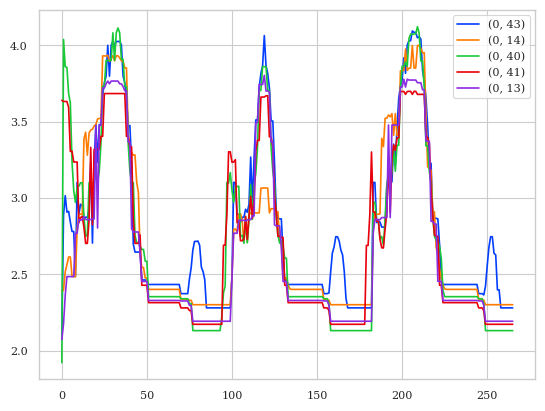

In [11]:
comb_total = {comb: sum(score) for comb, score in combinations_scores.items()}
n_best = sorted(comb_total, key=comb_total.get, reverse=True)[:5]

print("Best pairs of solvers:")
for i, comb in enumerate(n_best):
    plt.plot(combinations_scores[comb], label=comb)

    print(i)
    for id in comb:
        default = all_solvers[id].use_defaults()
        conf = solver_space.config_from_decision(decision=default, optimized_only=True)
        print(solver_space.format_config(conf))
    print()
plt.legend()

In [25]:
from tqdm import tqdm
import itertools
from solver_selector.solver_selector import make_solver_selector
from thermal_solvers import make_thermal_solver_space

from thermal_solvers import DirectSolverNode, ForkNode


solver_space = make_thermal_solver_space("full")
# solver_space = ForkNode([DirectSolverNode(), DirectSolverNode(name='direct1')])
all_solvers = solver_space.get_all_solvers()

solver_selector = make_solver_selector(
    solver_space,
    params={
        "exploration": 0,
        "load_statistics_paths": get_newest_data_paths(
            "thermal_many_solvers_gp", n_newest=1
        ),
    },
)

solver_scores = {}

for i, performance_predictor in enumerate(solver_selector.predictors):
    print(i)
    assert performance_predictor.is_initialized
    scores = []
    for entry in data["Many solvers gp"][0]:
        solver = performance_predictor.select_solver_parameters(
            entry.prediction.context
        )
        scores.append(solver.score)
    solver_scores[i] = np.array(scores)

new_combinations_scores = {}

for comb in itertools.combinations(range(len(all_solvers)), 2):
    s0_scores = solver_scores[comb[0]]
    s1_scores = solver_scores[comb[1]]
    new_combinations_scores[comb] = np.maximum(s0_scores, s1_scores)

Selecting from 45 solvers.
0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
1 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=upper]
2 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=lower]
3 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=full]
4 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=upper]
5 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - amg, method=lower]
6 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=full]
7 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=upper]
8 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - direct, method=lower]
9 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]
10 fgmres - schur_cd [primary - amg, s

Best pairs of solvers:
0
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - cpr [primary - amg, secondary - ilu]

1
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - schur_cd [primary - amg, secondary - amg, method=upper]

2
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
fgmres - schur_cd [primary - amg, secondary - amg, method=lower]

3
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
gmres - schur_cd [primary - amg, secondary - amg, method=lower]

4
fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
fgmres - schur_cd [primary - amg, secondary - amg, method=upper]



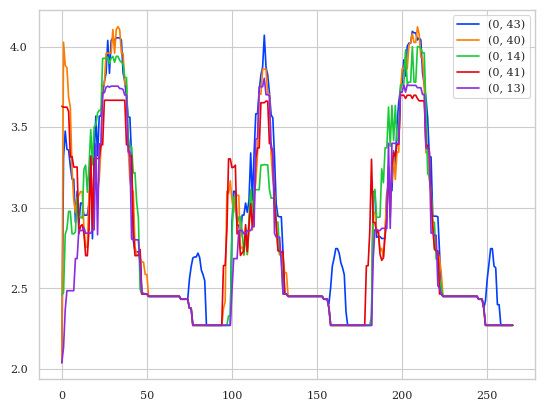

In [26]:
comb_total = {comb: sum(score) for comb, score in new_combinations_scores.items()}
n_best = sorted(comb_total, key=comb_total.get, reverse=True)[:5]

print("Best pairs of solvers:")
for i, comb in enumerate(n_best):
    plt.plot(new_combinations_scores[comb], label=comb)

    print(i)
    for id in comb:
        default = all_solvers[id].use_defaults()
        conf = solver_space.config_from_decision(decision=default, optimized_only=True)
        print(solver_space.format_config(conf))
    print()
plt.legend()

In [66]:
from data_scripts import make_num_linear_iters

solver_total = {solv: sum(score) for solv, score in solver_scores.items()}
n_best = sorted(solver_total, key=solver_total.get, reverse=True)[:10]

d = solver_selector._sort_decisions_for_predictors(data['Many solvers gp'][0])

for i in n_best:
    default = all_solvers[i].use_defaults()
    conf = solver_space.config_from_decision(decision=default, optimized_only=True)
    print(i, len(make_num_linear_iters(d[i], converged=CONVERGED)), solver_space.format_config(conf))

14 88 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]
0 12 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
41 115 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
40 168 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
12 140 fgmres - schur_cd [primary - amg, secondary - amg, method=full]
39 281 gmres - schur_cd [primary - amg, secondary - amg, method=full]
43 152 gmres - cpr [primary - amg, secondary - ilu]
13 92 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
11 15 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=lower]
9 22 fgmres - schur_cd [primary - amg, secondary - gmres [amg, restart=10], method=full]


In [65]:
make_num_linear_iters(d[11], converged=CONVERGED)

array([7, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6, 6, 6, 7, 6])

In [14]:
best_solvers_ids = list(set(item for pair in n_best for item in pair))
best_solvers = {i: all_solvers[i] for i in best_solvers_ids}

for i, sol in best_solvers.items():
    default = sol.use_defaults()
    conf = solver_space.config_from_decision(decision=default, optimized_only=True)
    print(i, solver_space.format_config(conf))

0 fgmres - schur_cd [primary - gmres [amg, restart=10], secondary - gmres [amg, restart=10], method=full]
40 gmres - schur_cd [primary - amg, secondary - amg, method=upper]
41 gmres - schur_cd [primary - amg, secondary - amg, method=lower]
43 gmres - cpr [primary - amg, secondary - ilu]
13 fgmres - schur_cd [primary - amg, secondary - amg, method=upper]
14 fgmres - schur_cd [primary - amg, secondary - amg, method=lower]


In [33]:
d = solver_selector._sort_decisions_for_predictors(data['Many solvers gp'][0])[0]
restarts = [x.config['fgmres']['preconditioner']['schur_cd']['primary']['gmres']['restart'] for x in d]
restarts

[28, 18, 11, 5]

In [39]:
d = solver_selector._sort_decisions_for_predictors(data['Many solvers gp'][0])
[(i, len(x)) for i, x in enumerate(d)]
d[39][0].config

{'gmres': {'preconditioner': {'schur_cd': {'primary': {'none': {'preconditioner': {'amg': {}}}},
    'secondary': {'none': {'preconditioner': {'amg': {}}}},
    'method': 'full'}},
  'tol': 1e-10,
  'restart': 30,
  'maxiter': 10}}